# Ratings and their impact on prices of Airbnb properties in London.

Airbnb states that hosts benefit from better reviews in a variety of ways. One of the main ways is through higher earnings. While the question of higher earnings should include an analysis of price and occupancy, due to the lack of data in the available dataset, this notebook focuses on price only. It attempts to answer the following questions:

### 1. How are units distributed across London?
### 2. How are prices distibuted across London?
### 3. What are the most common number of bedrooms in London's Airbnb?  
### 4. What are the most common types of properites on Airbnb in London?
### 5. Do higher ratings lead to a permium in price for Airbnb properties in London?

### Imports

In [1]:
import airbnb_analysis as airbnb
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn import preprocessing as prep
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Reading the dataset

In [2]:
df = pd.read_csv('csv/all_data/detailed/london 2.csv')
df.index=df['id']

In [3]:
schema = pd.read_csv('csv/data_dict.csv')

In [4]:
#Dropping unecessary columns
df.drop(columns=['id', 'bathrooms', 'license', 'neighbourhood','host_total_listings_count', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood','calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped'],inplace=True)


### Formatting and cleaning the data

#### Formatting the date columns

In [5]:
#Get the date columns based on the schema
date_cols=schema['Field'][(schema['Type']=='date') | (schema['Type']=='datetime')]

#Remove those date columns that are not relevant (deleted in the previous step)
date_cols=[col for col in date_cols if col in df.columns]

#Format date cols as datetime
for col in df[date_cols]:
    df[col]=pd.to_datetime(df[col], infer_datetime_format=True, format='%d-%m-%Y')
    

#### Formatting the boolean columns

In [6]:
#Get the boolean columns based on the schema
bool_cols=schema['Field'][(schema['Type']=='boolean [t=true; f=false]') | (schema['Type']=='boolean')]

#Remove those boolean columns that are not relevant (deleted in the previous step)
bool_cols=[col for col in bool_cols if col in df.columns]

#Checking that bool cols are actually not formatted as boolean dtype
#df[bool_cols].dtypes

#Format boolean cols as boolean dtype
df[bool_cols]=df[bool_cols].apply(lambda col: col=='t')

#### Cleaning -  Getting numeric and rating columns

In [7]:
#Getting numeric and rating columns
numeric_cols=df.columns[df.dtypes==np.number]

#List comprehension that get's the rating columns
rating_cols = [col_str for col_str in numeric_cols if col_str.split('_')[0]=='review']

In [8]:
#Converting price to float
df['price']=df['price'].str.replace('$','')
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype(float)

/var/folders/c4/hn_h0wj93dv87xfrnz95305r0000gn/T/ipykernel_43314/3223713010.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price']=df['price'].str.replace('$','')


In [9]:
df = df[
    [
    'host_is_superhost', 'neighbourhood_cleansed', 'property_type', 'room_type', 
    'bedrooms', 'amenities', 'price', 'number_of_reviews','review_scores_rating'
    ]
]
df = df.rename(columns={'neighbourhood_cleansed':'borough'})

In [10]:
#checking the shape and making a copy for use in the first 4 questions.
df.shape
original_df = df.copy()

In [11]:
df.dtypes

host_is_superhost          bool
borough                  object
property_type            object
room_type                object
bedrooms                float64
amenities                object
price                   float64
number_of_reviews         int64
review_scores_rating    float64
dtype: object

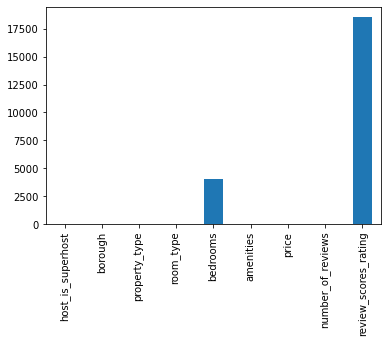

In [12]:
#variables that has NA in them
df.isna().sum().plot(kind='bar');

In [13]:
df.describe()

bedrooms         price  number_of_reviews  review_scores_rating
count  62624.000000  66641.000000       66641.000000          48082.000000
mean       1.489253    145.207230          15.651086              4.540116
std        0.883943    349.932373          36.777232              0.913813
min        1.000000      0.000000           0.000000              0.000000
25%        1.000000     46.000000           0.000000              4.500000
50%        1.000000     83.000000           3.000000              4.810000
75%        2.000000    145.000000          14.000000              5.000000
max       22.000000  18557.000000         974.000000              5.000000

The data above suggests that two important variables have nan's in them. The bedrooms and review_scores_rating vars which would be used in the analysis below. Hence observations with nan for those are going to be dropped. Furthermore, price has a minimum of 0. Those should be dropped as no valid property should reasonably hold that price. The max is also at 18,557 which seems suspiciously high for a daily price. We can also observe that 75% of bedrooms are at most two bedrooms. This will be looked at further below.

#### Dropping nan's in bedrooms and reivew_scores_rating

In [14]:
df = df.dropna(subset=['bedrooms','review_scores_rating'])

In [15]:
df.shape

(45474, 9)

In [16]:
df['number_of_reviews'].describe()

count    45474.000000
mean        21.540485
std         41.324778
min          1.000000
25%          2.000000
50%          7.000000
75%         22.000000
max        868.000000
Name: number_of_reviews, dtype: float64

#### Now, we need to see how many units have sufficient ratings in the first place.

In [17]:
thresh=4
df[df['number_of_reviews']>=thresh]['number_of_reviews'].value_counts().sum()

30104

In [18]:
df['number_of_reviews'].value_counts().sum()

45474

#### Turns out that 66% of the data has 4 or more reviews. We'll stick with that as a threshold and anything with less than 4 reviews will be eliminated. The reason is that the less reviews we have, the more likely that the reviews will be skewed due to the low number of reviews rather than the nature of the data.

0.662004662004662

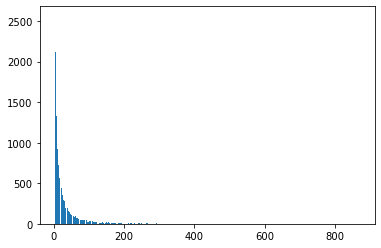

In [19]:
plt.bar(df[df['number_of_reviews']>=thresh]['number_of_reviews'].value_counts().index,df[df['number_of_reviews']>=thresh]['number_of_reviews'].value_counts())
df[df['number_of_reviews']>=thresh]['number_of_reviews'].value_counts().sum()/df['number_of_reviews'].value_counts().sum()


In [20]:
df=df[df['number_of_reviews']>=4]


In [21]:
df.shape

(30104, 9)

In [22]:
df[df['price']<20]

host_is_superhost        borough  \
id                                           
200713                 True        Croydon   
388700                False         Merton   
422748                 True        Croydon   
547462                 True  Tower Hamlets   
574475                False         Ealing   
...                     ...            ...   
50037220               True         Bexley   
50592352              False         Barnet   
50637636              False        Hackney   
51107156               True         Bexley   
52045532              False         Merton   

                                property_type     room_type  bedrooms  \
id                                                                      
200713              Private room in townhouse  Private room       1.0   
388700            Private room in rental unit  Private room       1.0   
422748              Private room in townhouse  Private room       1.0   
547462            Private room in rental unit  Private room       1.0   
574475       Private room in residential home  Private room       1.0   
...                                       ...           ...       ...   
50037220          Private room in rental unit  Private room       1.0   
50592352                Shared room in hostel   Shared room       1.0   
50637636  Private room in condominium (condo)  Private room       1.0   
51107156            Private room in townhouse  Private room       1.0   
52045532   Shared room in condominium (condo)   Shared room       1.0   

                                                  amenities  price  \
id                                                                   
200713    ["Shampoo", "Washer", "Carbon monoxide alarm",...   18.0   
388700    ["Shampoo", "Heating", "Essentials", "First ai...   12.0   
422748    ["Shampoo", "Washer", "Carbon monoxide alarm",...   18.0   
547462    ["Hot water", "Heating", "TV with standard cab...   17.0   
574475    ["Hot water", "Heating", "Private entrance", "...   19.0   
...                                                     ...    ...   
50037220  ["Hot water", "Coffee maker", "Lockbox", "Firs...   18.0   
50592352  ["Washer", "Carbon monoxide alarm", "Heating",...   16.0   
50637636  ["Hot water", "Heating", "Coffee maker", "Firs...   16.0   
51107156  ["Hot water", "Heating", "Clothing storage", "...   17.0   
52045532  ["Hot water", "Radiant heating", "Bidet", "Hot...   17.0   

          number_of_reviews  review_scores_rating  
id                                                 
200713                   47                  4.46  
388700                   35                  4.86  
422748                   65                  4.46  
547462                  105                  4.84  
574475                   49                  4.83  
...                     ...                   ...  
50037220                 21                  4.76  
50592352                  4                  5.00  
50637636                  6                  4.67  
51107156                 14                  5.00  
52045532                  9                  4.78  

[292 rows x 9 columns]

They do seem somewhat legit given the amount of ratings as well as the fact that some of them are Superhosts. We'll keep them.

In [23]:
#This limits the list of apartments to those with at least 50 apartments for the categories of 1 and 2 bedrooms
df['borough'].value_counts()[df['borough'].value_counts()>50].sum()

30104

### Setting up key variables

In [24]:
total_properties=df.shape[0]
boroughs = list(df['borough'].unique())
no_boroughs = len(boroughs)
room_types = list(df['room_type'].unique())
no_room_types = len(room_types)
property_types = list(df['property_type'].unique())
no_property_type = len(property_types)

To recap after all exploration and cleaning above, here's where we are:

In [25]:
print(f"Number of properties in the dataset: {total_properties}")
print(f"Number of boroughs in the dataset: {no_boroughs}")
print(f"Number of property types in the dataset: {no_property_type}")
print(f"Number of room types in the dataset: {no_room_types}")

Number of properties in the dataset: 30104
Number of boroughs in the dataset: 33
Number of property types in the dataset: 70
Number of room types in the dataset: 4


### 1. How are units distributed across London? (based on out dataset)

/var/folders/c4/hn_h0wj93dv87xfrnz95305r0000gn/T/ipykernel_43314/2294146576.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=90, rotation=90)
/var/folders/c4/hn_h0wj93dv87xfrnz95305r0000gn/T/ipykernel_43314/2294146576.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=90);


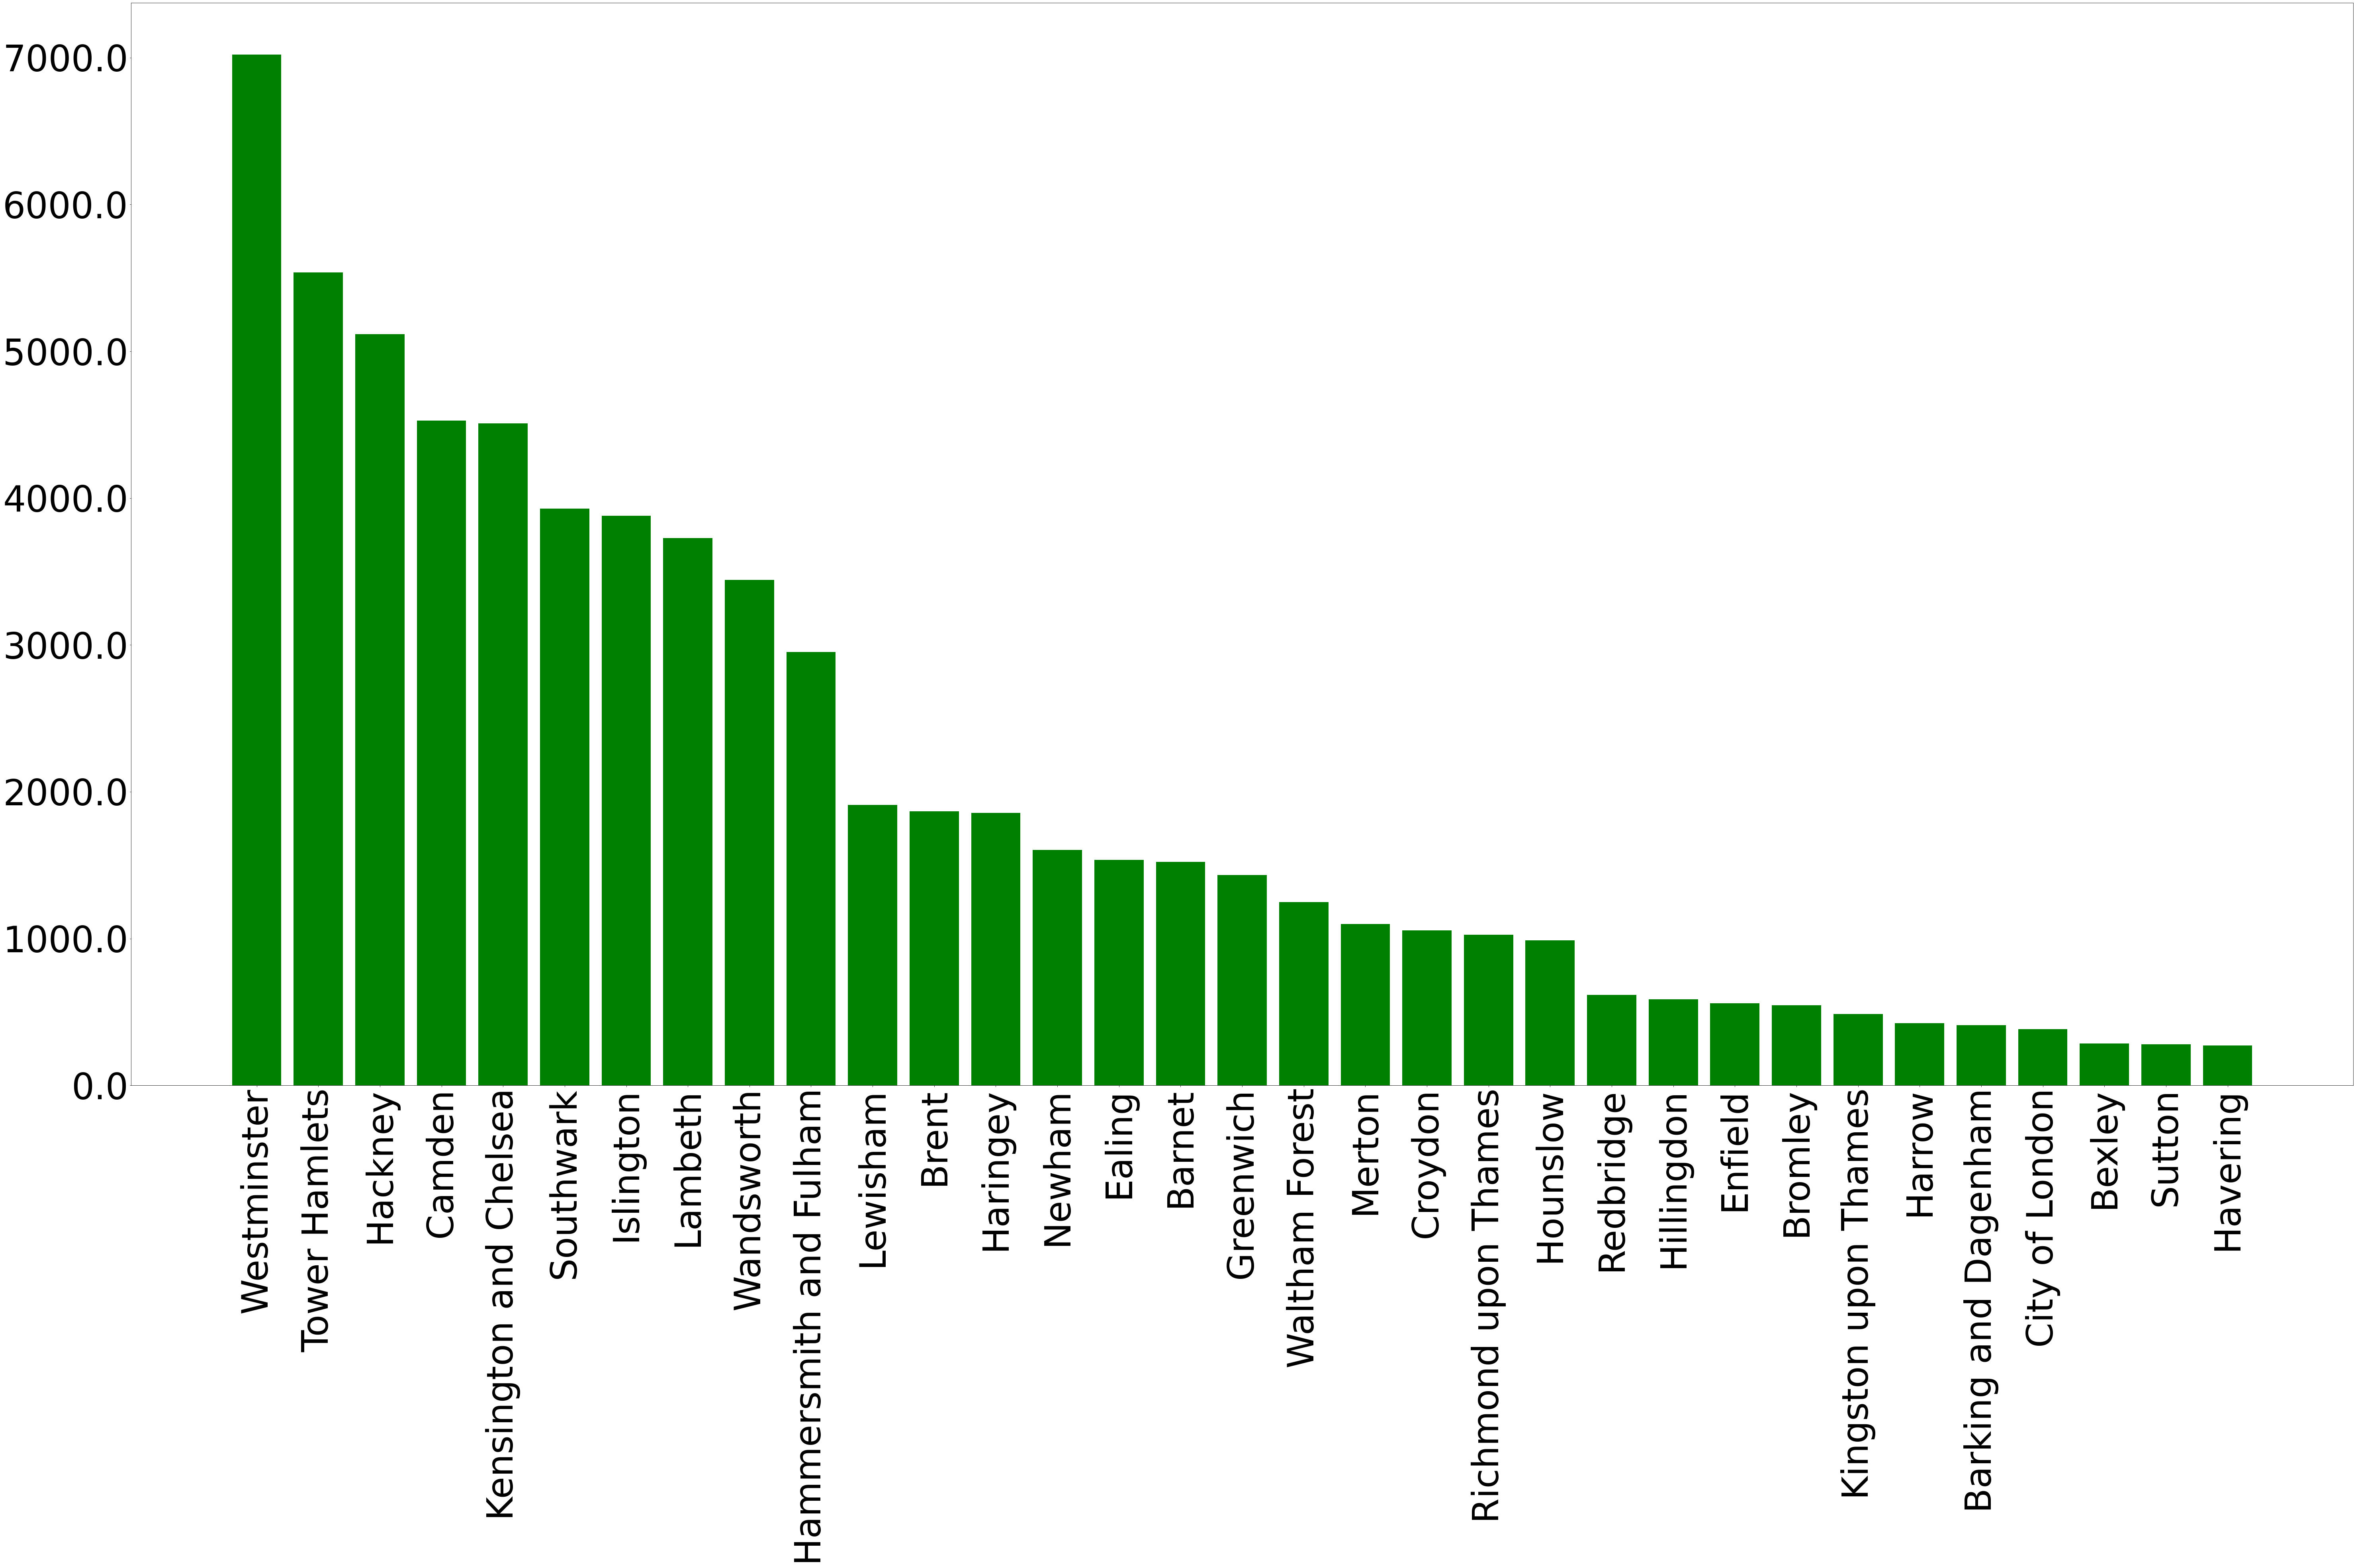

In [26]:
#unpacking the tuple returned to fig and ax variables
#You can resize the fig (which is the frame) but can't draw on it, the happens on the axis
fig, ax = plt.subplots(figsize=(100,50))
xlabels = original_df['borough'].value_counts().index
yvalues = original_df['borough'].value_counts()
ax.bar(xlabels,yvalues, color='green')

ax.set_xticklabels(xlabels, fontsize=90, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontsize=90);
fig.savefig('graphs/units_dist.png')

In [27]:
# set the filepath and load in a shapefile
fp = "statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...

In [28]:
#Merging geo mapping data to the airbnb dataset
merged_df = map_df.set_index("NAME").join(original_df['borough'].value_counts())

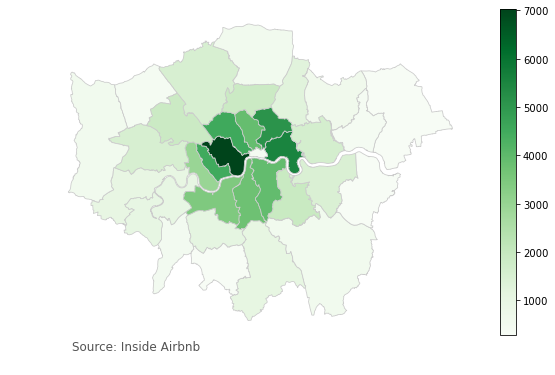

In [29]:
# set the range for the choropleth (borough is the count of units in a borough)
vmin, vmax = merged_df.borough.min(), merged_df.borough.max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

#Mapping
merged_df.plot(column='borough', cmap="Greens", linewidth=0.8, ax=ax, edgecolor='0.8');

#Removing Axis
ax.axis('off');

# create an annotation for the data source
ax.annotate('Source: Inside Airbnb',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment="left", verticalalignment="top", fontsize=12, color='#555555');

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

fig.savefig("graphs/unit_distribution_map.png", dpi=300)


In [30]:
original_df['borough'].value_counts()

Westminster               7022
Tower Hamlets             5538
Hackney                   5117
Camden                    4527
Kensington and Chelsea    4508
Southwark                 3929
Islington                 3879
Lambeth                   3727
Wandsworth                3442
Hammersmith and Fulham    2953
Lewisham                  1910
Brent                     1868
Haringey                  1856
Newham                    1604
Ealing                    1536
Barnet                    1523
Greenwich                 1434
Waltham Forest            1248
Merton                    1099
Croydon                   1055
Richmond upon Thames      1027
Hounslow                   988
Redbridge                  617
Hillingdon                 586
Enfield                    560
Bromley                    546
Kingston upon Thames       486
Harrow                     423
Barking and Dagenham       410
City of London             384
Bexley                     285
Sutton                     281
Havering

### 2. How are prices distributed across London? (based on our dataset)
(We need to add the map here)

In [31]:
mean_prices = original_df.groupby('borough')['price'].mean()
mean_prices.sort_values(inplace=True)

/var/folders/c4/hn_h0wj93dv87xfrnz95305r0000gn/T/ipykernel_43314/998334145.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, fontsize=40, rotation=90)
/var/folders/c4/hn_h0wj93dv87xfrnz95305r0000gn/T/ipykernel_43314/998334145.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=40);


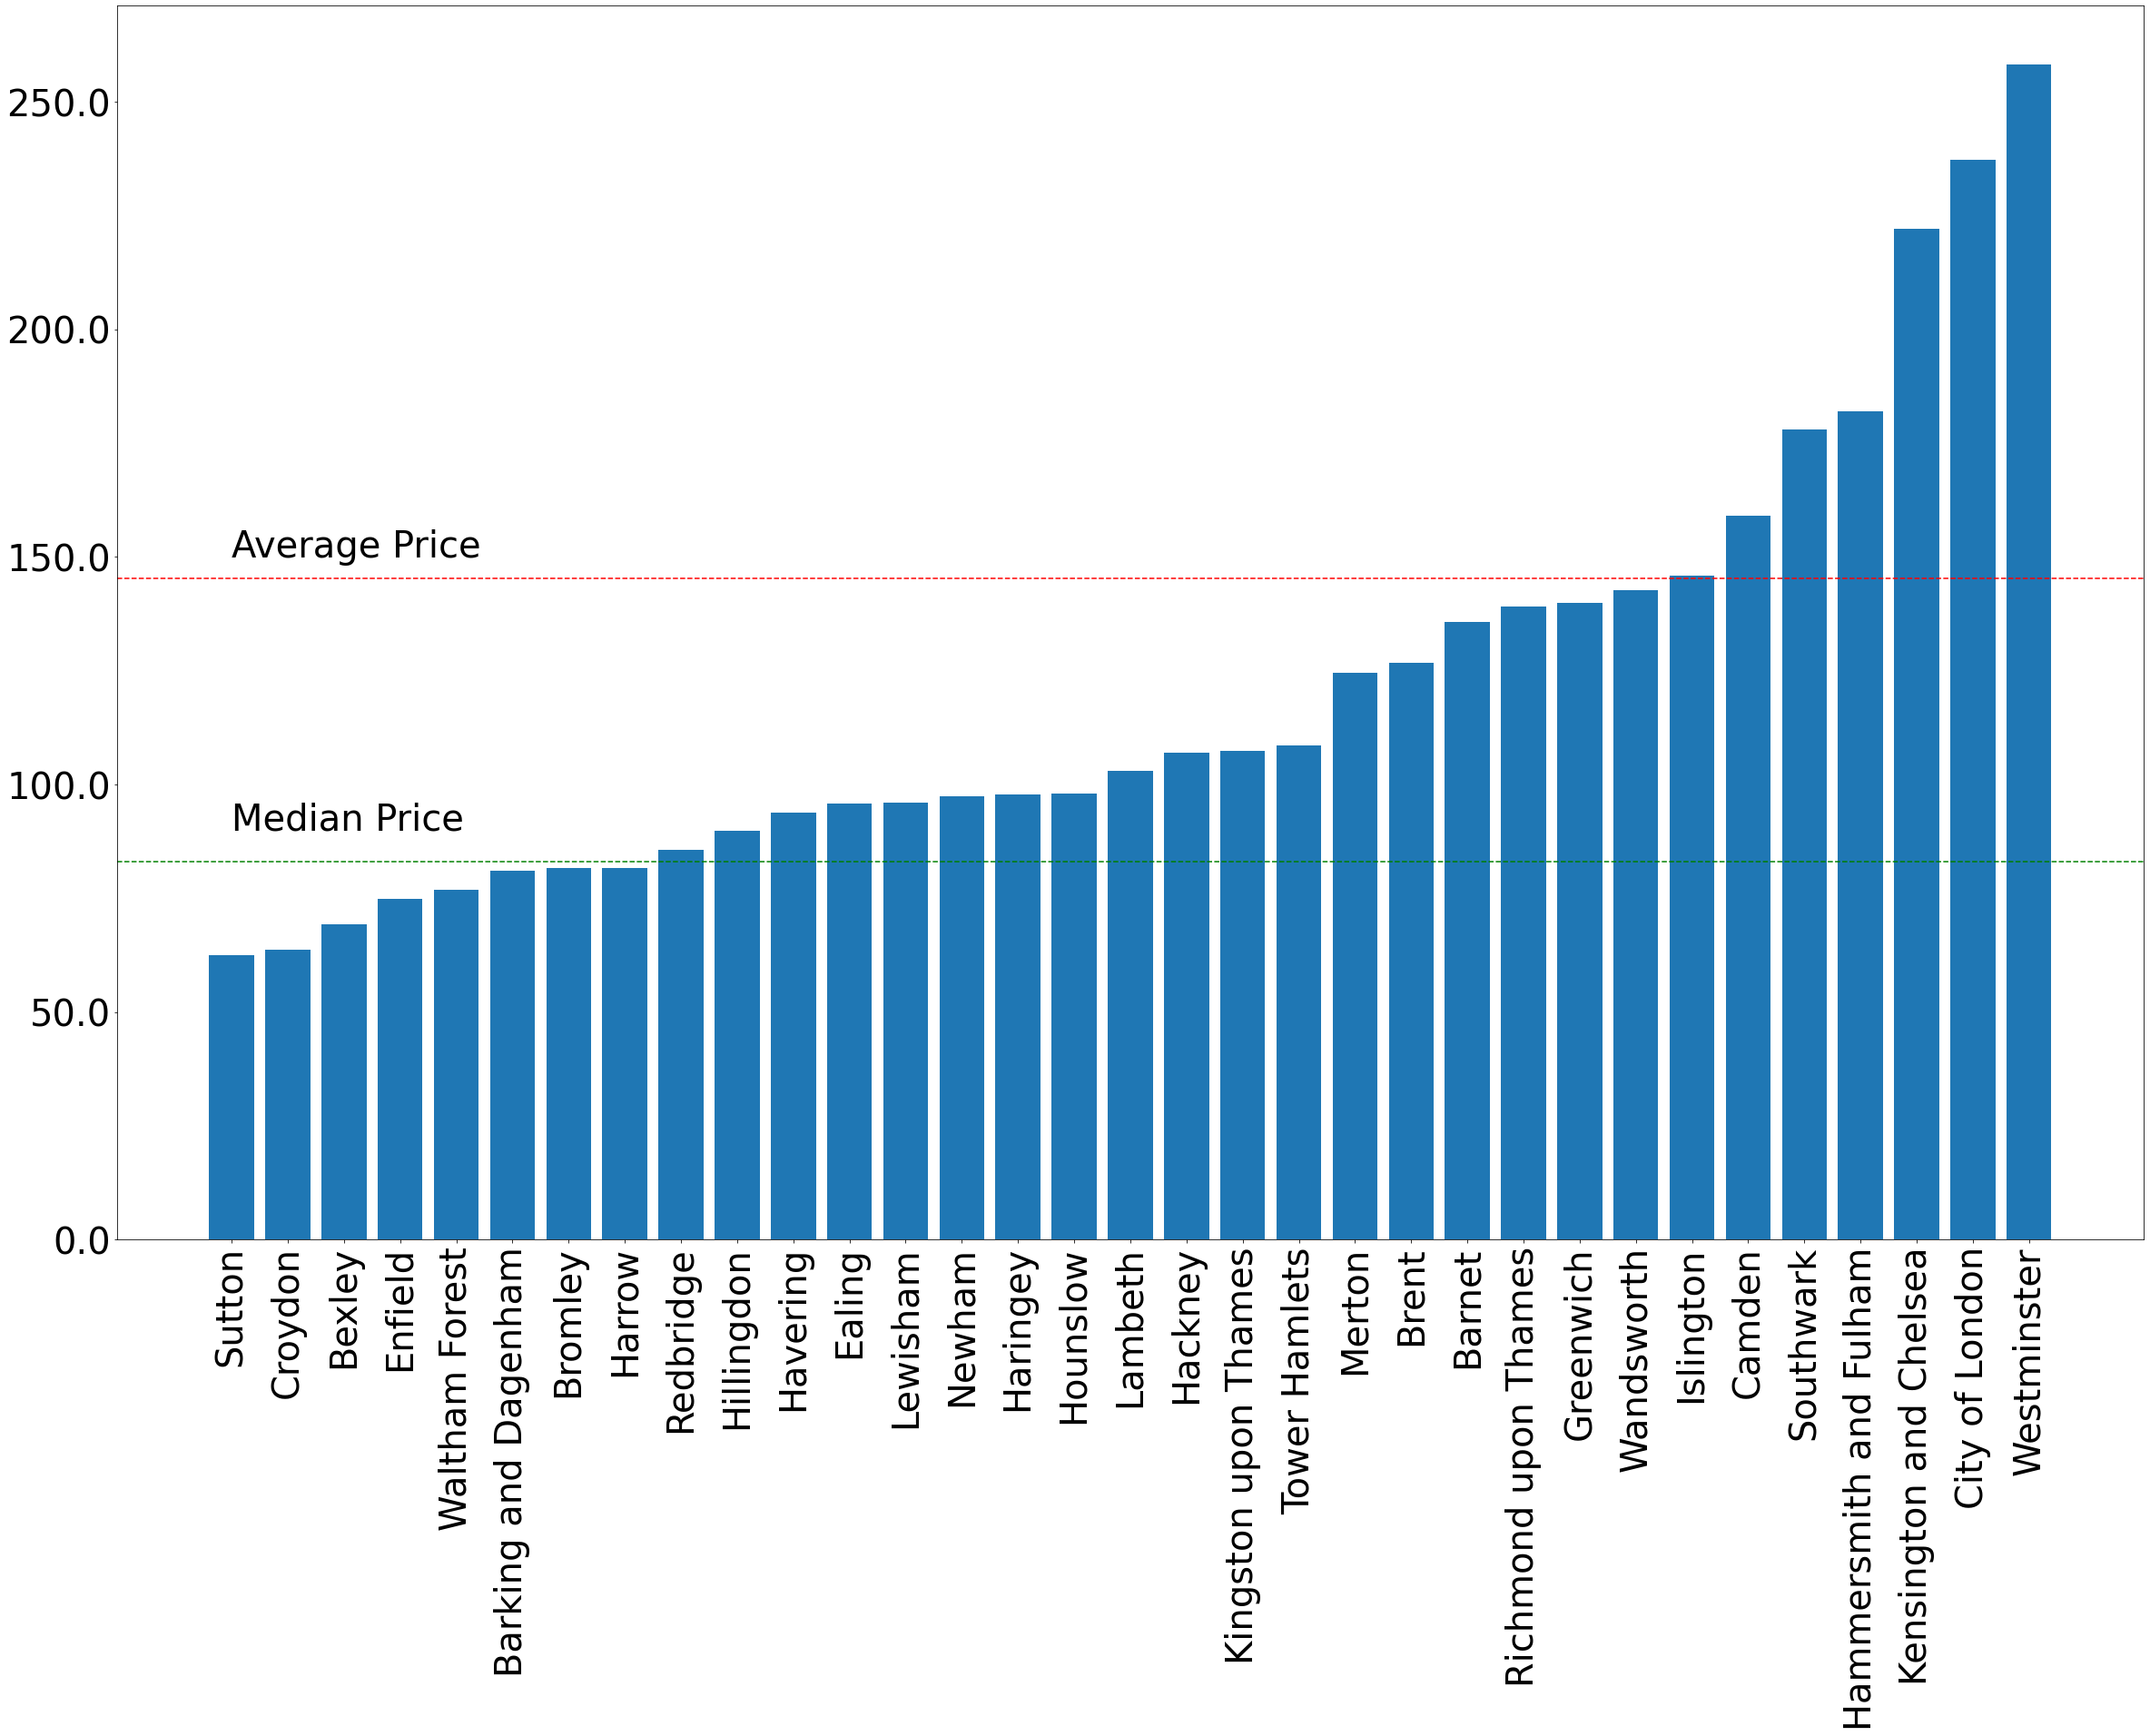

In [32]:
fig, ax = plt.subplots(figsize=(40,25))

xlabels = mean_prices.index
yvalues = mean_prices.values

ax.bar(xlabels,yvalues)
ax.set_xticklabels(xlabels, fontsize=40, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontsize=40);

ax.axhline(original_df['price'].mean(), color='red', linestyle='--')
ax.axhline(original_df['price'].median(), color='green', linestyle='--')

ax.annotate('Average Price', xy=(1, 150), xytext=(0, 150), fontsize=40)
ax.annotate('Median Price', xy=(2, 90), xytext=(0, 90), fontsize=40)

fig.savefig('graphs/prices_bar.png')

In [33]:
# set the filepath and load in a shapefile
fp = "statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER SUB_2009  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F     None   
1               Croydon  E09000008   8649.441       0.000         F     None   
2               Bromley  E09000006  15013.487       0.000         F     None   
3              Hounslow  E09000018   5658.541      60.755         F     None   
4                Ealing  E09000009   5554.428       0.000         F     None   

  SUB_2006                                           geometry  
0     None  POLYGON ((516401.600 160201.800, 516407.300 16...  
1     None  POLYGON ((535009.200 159504.700, 535005.500 15...  
2     None  POLYGON ((540373.600 157530.400, 540361.200 15...  
3     None  POLYGON ((521975.800 178100.000, 521967.700 17...  
4     None  POLYGON ((510253.500 182881.600, 510249.900 18...

In [34]:
#Merging geo mapping data to the airbnb dataset
merged_df = map_df.set_index("NAME").join(mean_prices)

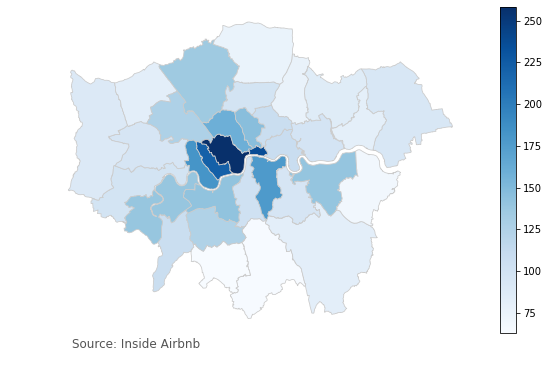

In [35]:
# set the range for the choropleth
vmin, vmax = merged_df.price.min(), merged_df.price.max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

#Mapping
merged_df.plot(column='price', cmap="Blues", linewidth=0.8, ax=ax, edgecolor='0.8');

#Removing Axis
ax.axis('off');

# create an annotation for the data source
ax.annotate('Source: Inside Airbnb',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment="left", verticalalignment="top", fontsize=12, color='#555555');

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

fig.savefig("graphs/prices_map.png", dpi=300)


#### Prices per type of bedrooms differ. The larger the number of bedrooms the higher the price

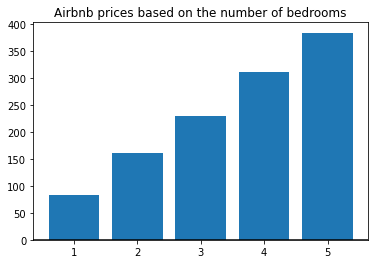

In [36]:
#Makes sense, 2 bhk is almost double 1
room_mean_prices = df[df['bedrooms']<6].groupby('bedrooms')['price'].mean()
mean_prices.sort_values(inplace=True)
plt.bar(x=room_mean_prices.index, height=room_mean_prices.values)
plt.axhline(0, color='black')
plt.title(f'Airbnb prices based on the number of bedrooms', fontsize=12)
plt.xticks(ticks=range(1,6))
plt.show()

#### As expected, Entire homes attract a higher price than shared properties

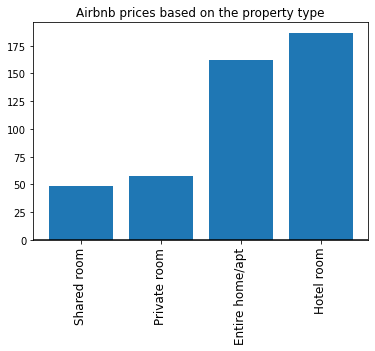

In [37]:
type_mean_prices = df[df['room_type'].isin(room_types)].groupby('room_type')['price'].mean()
type_mean_prices.sort_values(inplace=True)
plt.bar(x=type_mean_prices.index, height=type_mean_prices.values)
plt.axhline(0, color='black')
plt.title(f'Airbnb prices based on the property type', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.show()

#### This also applied to a broaded category

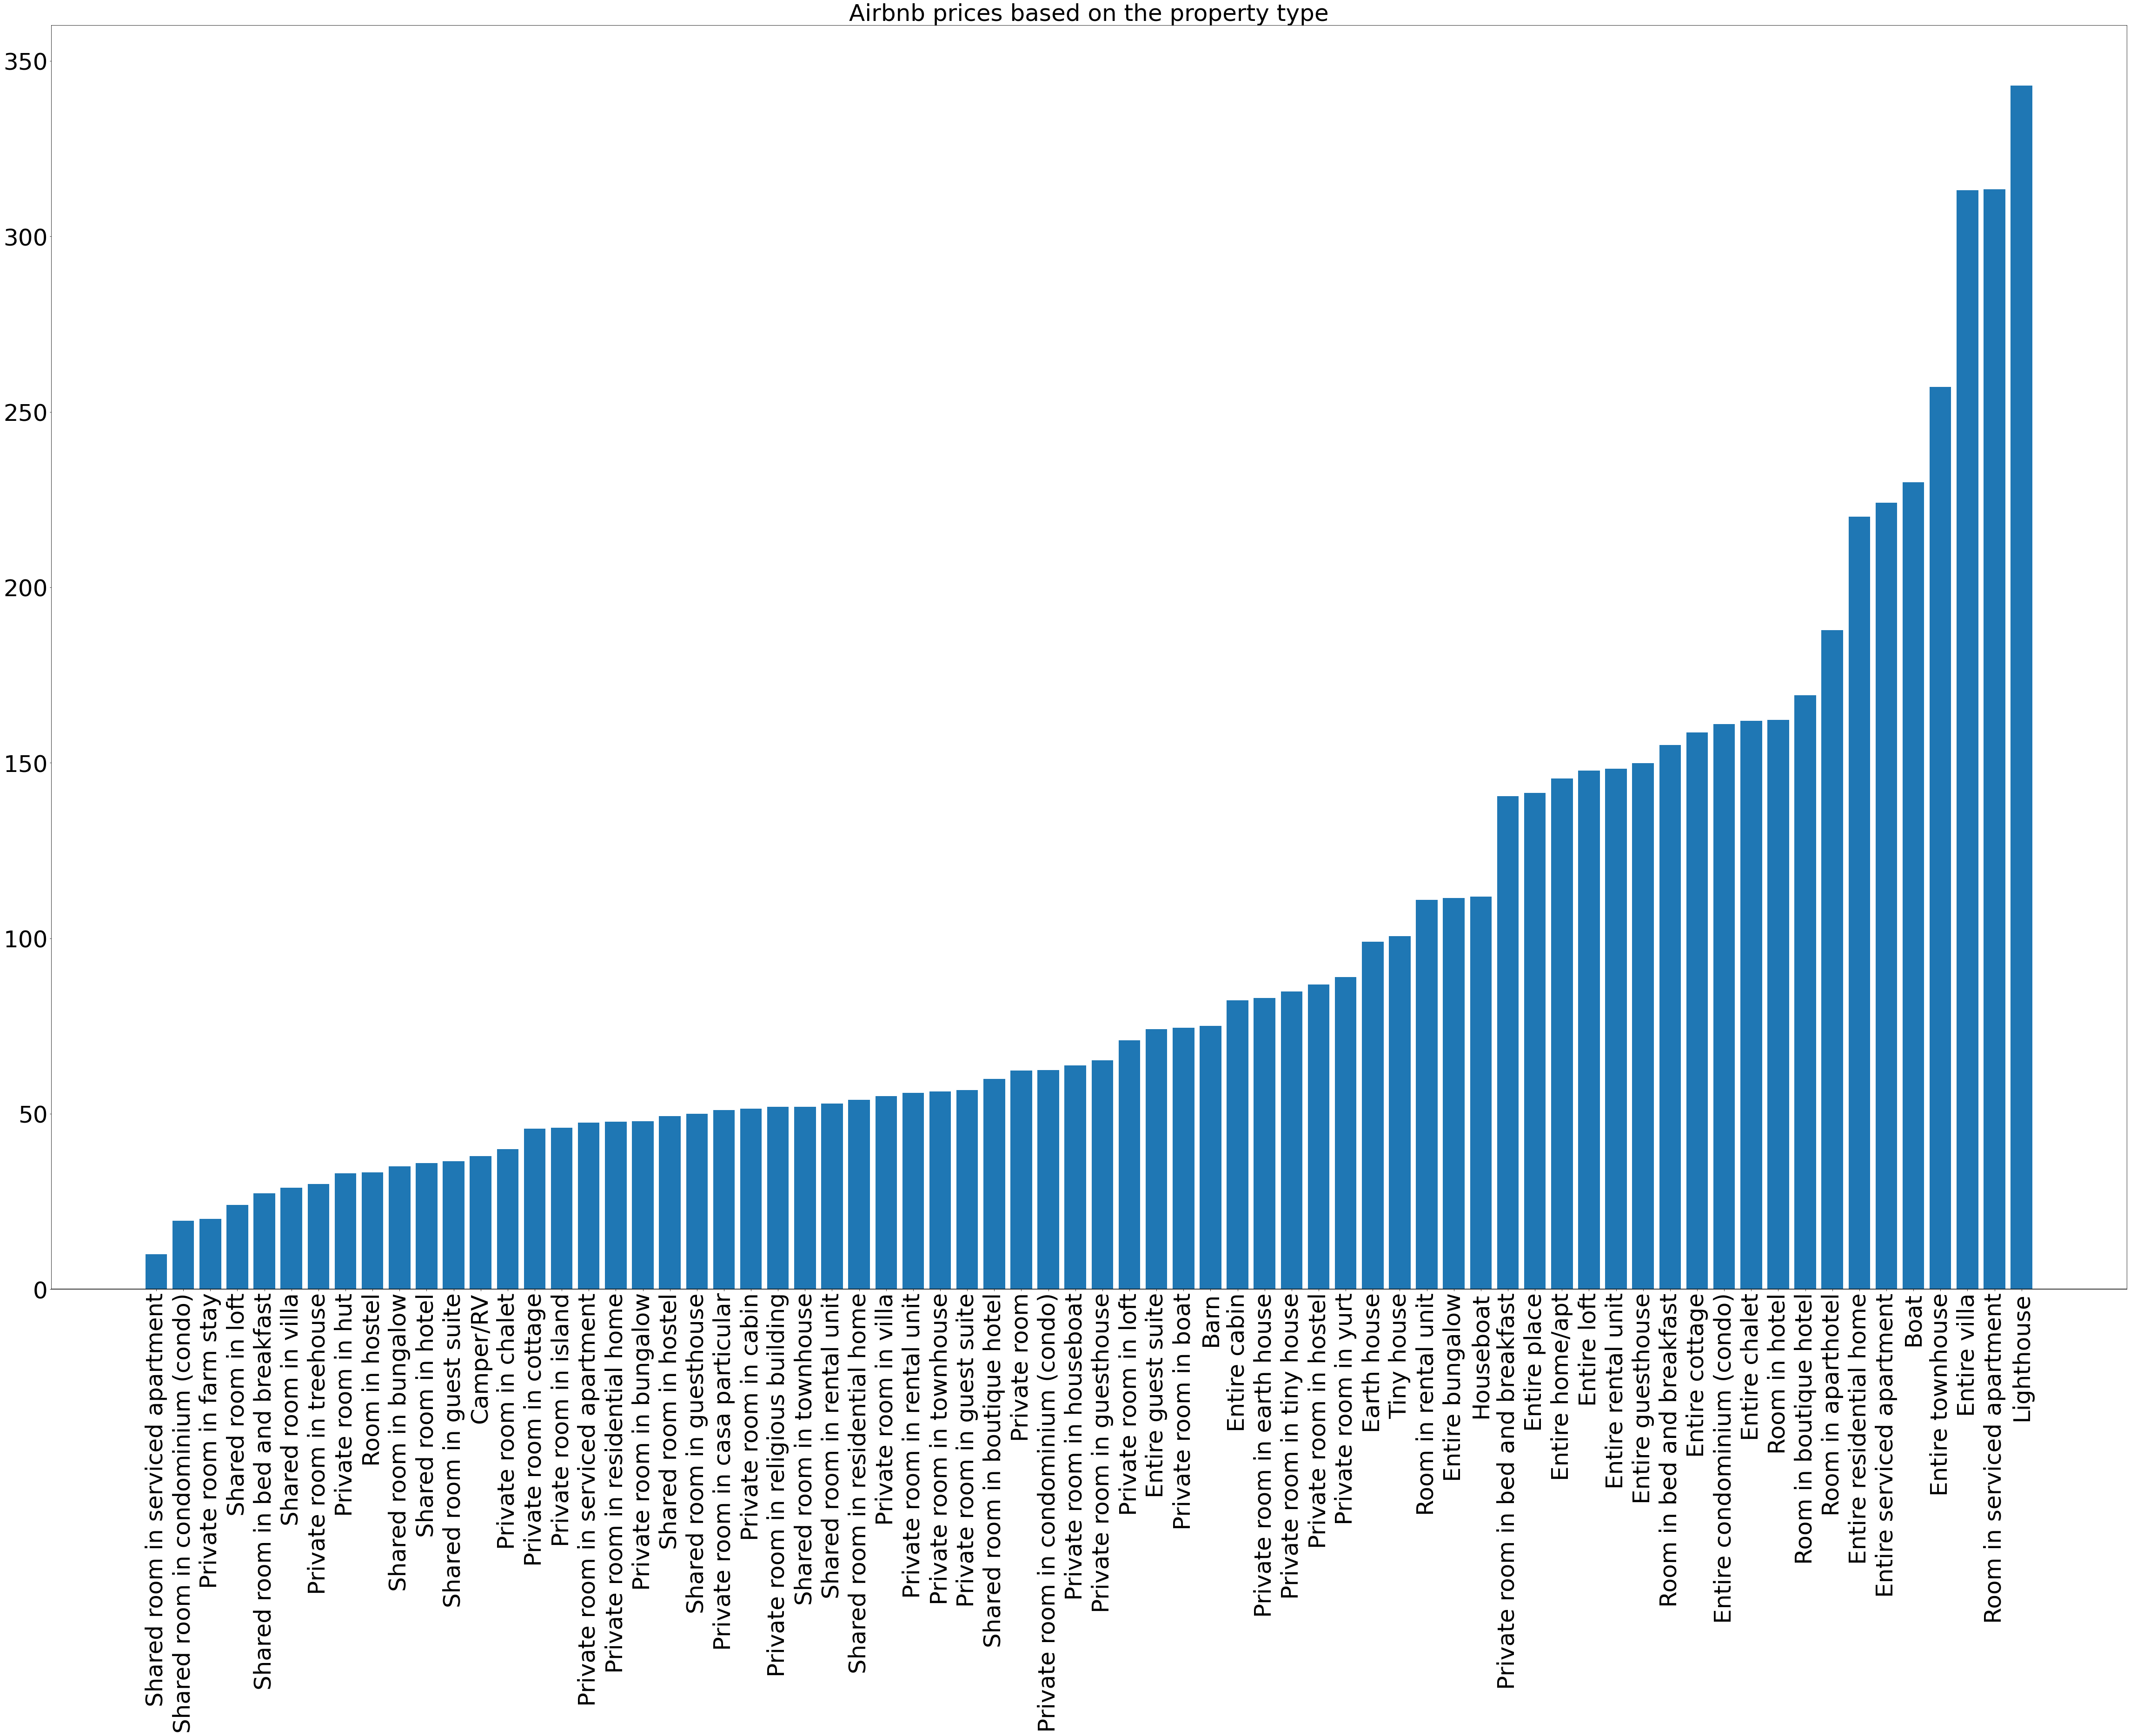

In [38]:
type_mean_prices = df[df['property_type'].isin(property_types)].groupby('property_type')['price'].mean()
type_mean_prices.sort_values(inplace=True)
plt.figure(figsize=(80,50))
plt.bar(x=type_mean_prices.index, height=type_mean_prices.values)
plt.axhline(0, color='black')
plt.title(f'Airbnb prices based on the property type', fontsize=50)
plt.xticks(rotation=90, fontsize=50)
plt.yticks(fontsize=50)
plt.show()

In [39]:
type_mean_prices

property_type
Shared room in serviced apartment      10.000000
Shared room in condominium (condo)     19.500000
Private room in farm stay              20.000000
Shared room in loft                    24.000000
Shared room in bed and breakfast       27.400000
                                         ...    
Boat                                  229.937500
Entire townhouse                      257.058076
Entire villa                          313.142857
Room in serviced apartment            313.450000
Lighthouse                            343.000000
Name: price, Length: 70, dtype: float64

### 3. What are the most common number of bedrooms in London's Airbnb?  

In [40]:
original_df['bedrooms'].value_counts()

1.0     42746
2.0     12817
3.0      4500
4.0      1791
5.0       579
6.0       132
7.0        28
8.0        10
10.0        7
12.0        4
9.0         4
16.0        3
22.0        1
11.0        1
21.0        1
Name: bedrooms, dtype: int64

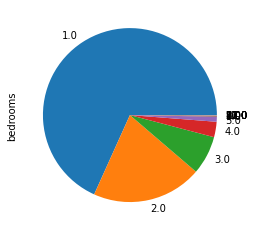

In [41]:
original_df['bedrooms'].value_counts().sort_index().plot(kind='pie');

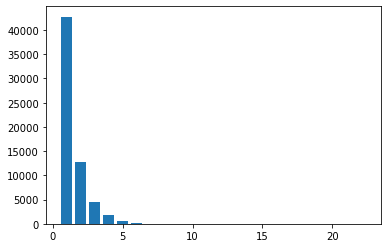

In [42]:
fig, ax = plt.subplots()
ax.bar(original_df['bedrooms'].value_counts().index, original_df['bedrooms'].value_counts());
fig.savefig('graphs/no_bedrooms.png')


In [43]:
xvalues = original_df.groupby('bedrooms')['price'].mean().index
yvalues = original_df.groupby('bedrooms')['price'].mean().values


### 4. What are the most common property types/room types in London's Airbnb?  

### Properties types

In [44]:
labeled_list=original_df['property_type'].value_counts()[original_df['property_type'].value_counts()>500]
labeled_list['Other']=original_df['property_type'].value_counts()[original_df['property_type'].value_counts()<=500].sum()
labeled_list

Entire rental unit                     25294
Private room in rental unit            14340
Private room in residential home        9109
Entire residential home                 5119
Entire condominium (condo)              3764
Private room in townhouse               1334
Private room in condominium (condo)     1332
Entire serviced apartment               1206
Entire townhouse                         968
Other                                   4175
Name: property_type, dtype: int64

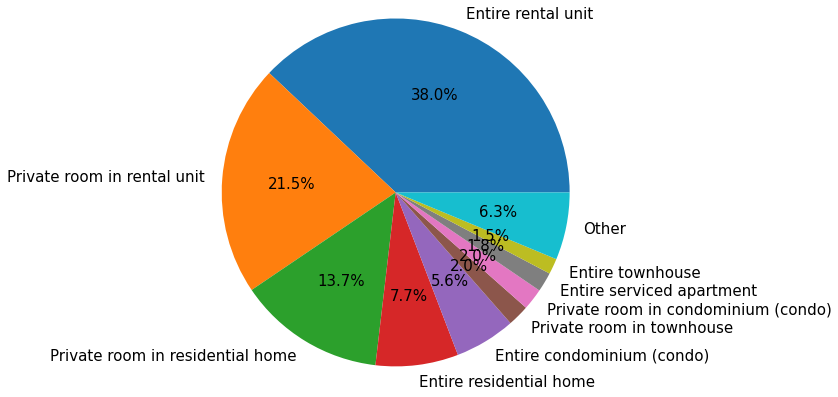

In [45]:
plt.rcParams['font.size']=15
plt.pie(labeled_list, labels=labeled_list.index, radius=2, autopct='%.1f%%');

### Rooms types

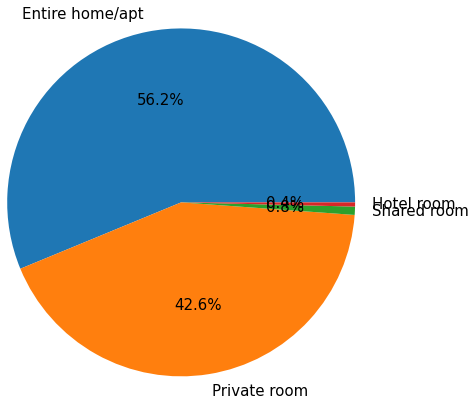

In [46]:
plt.rcParams['font.size']=15
plt.pie(
        original_df['room_type'].value_counts(), 
        labels=original_df['room_type'].value_counts().index, 
        radius=2, 
        autopct='%.1f%%'
        );


In order to step into the analysis of the relation between Airbnb properites and review scores in London, 
we will focus on the following:  
1) Only 1 and 2 bedrooms  
2) Only properties with 4 or more reviews

In [47]:
df = df[(df['bedrooms']<3)&(df['room_type'].isin(['Entire home/apt','Private room']))]

In [48]:
df.shape

(26757, 9)

In [49]:
total_properties=df.shape[0]
boroughs = list(df['borough'].unique())
no_boroughs = len(boroughs)
room_types = list(df['room_type'].unique())
no_room_types = len(room_types)
property_types = list(df['property_type'].unique())
no_property_type = len(property_types)

In [50]:
print(f"Number of properties in the dataset: {total_properties}")
print(f"Number of boroughs in the dataset: {no_boroughs}")
print(f"Number of property types in the dataset: {no_property_type}")
print(f"Number of room types in the dataset: {no_room_types}")

Number of properties in the dataset: 26757
Number of boroughs in the dataset: 33
Number of property types in the dataset: 49
Number of room types in the dataset: 2


### 5. Do higher ratings lead to a permium in price for Airbnb properties in London?

### Example of 1 bedrooms, entire property in Westminister - comparison between below and above average rating prices

In [51]:
# Mean price for a 1 bed, entire property in Westminster
fltr = (df['bedrooms']==1) & (df['room_type']=='Entire home/apt') & (df['borough']=='Westminster')
mean_fltr = df[fltr]['review_scores_rating'].mean()
mean_fltr_price = df[fltr]['price'].mean()
above = df[fltr & (df['review_scores_rating']>mean_fltr)][['price', 'review_scores_rating']]
below = df[fltr & (df['review_scores_rating']<=mean_fltr)][['price','review_scores_rating']]

In [52]:
mean_fltr

4.653193950177938

In [53]:
mean_fltr_price

195.70106761565836

#### Premium for above average ratings

In [54]:
above.mean()

price                   208.108597
review_scores_rating      4.850166
dtype: float64

In [55]:
above['price'].mean()/mean_fltr_price-1

0.06340041891737114

#### Discount for below average rating

In [56]:
below.mean()

price                   177.856833
review_scores_rating      4.369913
dtype: float64

In [57]:
below['price'].mean()/mean_fltr_price-1

-0.09118107970112155

#### For Westminster, there is a larger number of properties that charge a premium for datasets with above average ratings vs. those with below average ratings.

In [58]:
#Spliting the data around the mean
above_means_df, below_means_df = airbnb.split_data(df, 'borough','bedrooms', 'room_type', 'review_scores_rating')


/Users/tn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [59]:
above_means_df[['price','review_scores_rating']].describe()

price  review_scores_rating
count  16514.000000          16514.000000
mean     103.749485              4.890476
std      263.071609              0.095854
min        8.000000              4.580000
25%       45.000000              4.820000
50%       78.000000              4.900000
75%      120.000000              5.000000
max    16706.000000              5.000000

In [60]:
below_means_df[['price','review_scores_rating']].describe()

price  review_scores_rating
count  10243.000000          10243.000000
mean      99.979596              4.439476
std      162.420938              0.335083
min        8.000000              0.000000
25%       40.000000              4.330000
50%       78.000000              4.500000
75%      120.000000              4.640000
max     7800.000000              4.900000

#### From the above, there is a hint that the hypothesis could be true. Average price for the above df is higher than that for the below.  Let's delve into the details

In [61]:
#Creating new columns that mark the rows that are rated above average, then combining the two datasets.
above_means_df['above_average_rating']=[True]*above_means_df.shape[0]
below_means_df['above_average_rating']=[False]*below_means_df.shape[0]
df_premium = pd.concat([above_means_df,below_means_df], ignore_index=True)
df_premium['premium']=df_premium['premium'].astype(bool)

In [62]:
#Checking that all the data still remains
above_means_df.shape[0]+below_means_df.shape[0]==total_properties

True

#### Overall, 33% of the properties fetch a premium. Let's see how the segregated data looks like

In [92]:
##Properties with premium vs. not (Overall)

print(f"Premium: {round(df_premium[df_premium['premium']==True].shape[0]/df_premium.shape[0],2)}")
print(f"No Premium: {round(df_premium[df_premium['premium']==False].shape[0]/df_premium.shape[0],2)}")

Premium: 0.33
No Premium: 0.67


#### Above average rated dataset ---> 35% receive premiums

In [108]:
##Properties with premium vs. not (above average ratings)
print(f"Premium: {round(above_means_df[above_means_df['premium']==True].shape[0]/above_means_df.shape[0],2)}")
print(f"No Premium: {round(above_means_df[above_means_df['premium']==False].shape[0]/above_means_df.shape[0],2)}")

Premium: 0.35
No Premium: 0.65


#### Below average rated dataset ---> 30% receive premiums

In [109]:
##Properties with premium vs. not (below average ratings)
print(f"Premium: {round(below_means_df[below_means_df['premium']==True].shape[0]/below_means_df.shape[0],2)}")
print(f"No Premium: {round(below_means_df[below_means_df['premium']==False].shape[0]/below_means_df.shape[0],2)}")

Premium: 0.3
No Premium: 0.7


#### For the below average rated dataset, there is a lower percentage of properties that fetch a premium compared to the overall data. 29.5%. Compared to the above average dataset, the difference is almost 19% 
## Units rated highly were 19% more likely to charge a higher price compared lower rated peers.

In [65]:
##Properties with premium vs. not (below average ratings)
df_premium['premium'][df_premium['above_average_rating']==False].value_counts()/df_premium['premium'][df_premium['above_average_rating']==False].value_counts().sum()


False    0.704188
True     0.295812
Name: premium, dtype: float64

### Now, diving into the categories further. 

The below chart compares the mean prices of highly rated properties vs. those for lower rated properties.
For example, in the City of London, the mean price for a property that is rated highly is double (100%) more than that of a property rated below average.

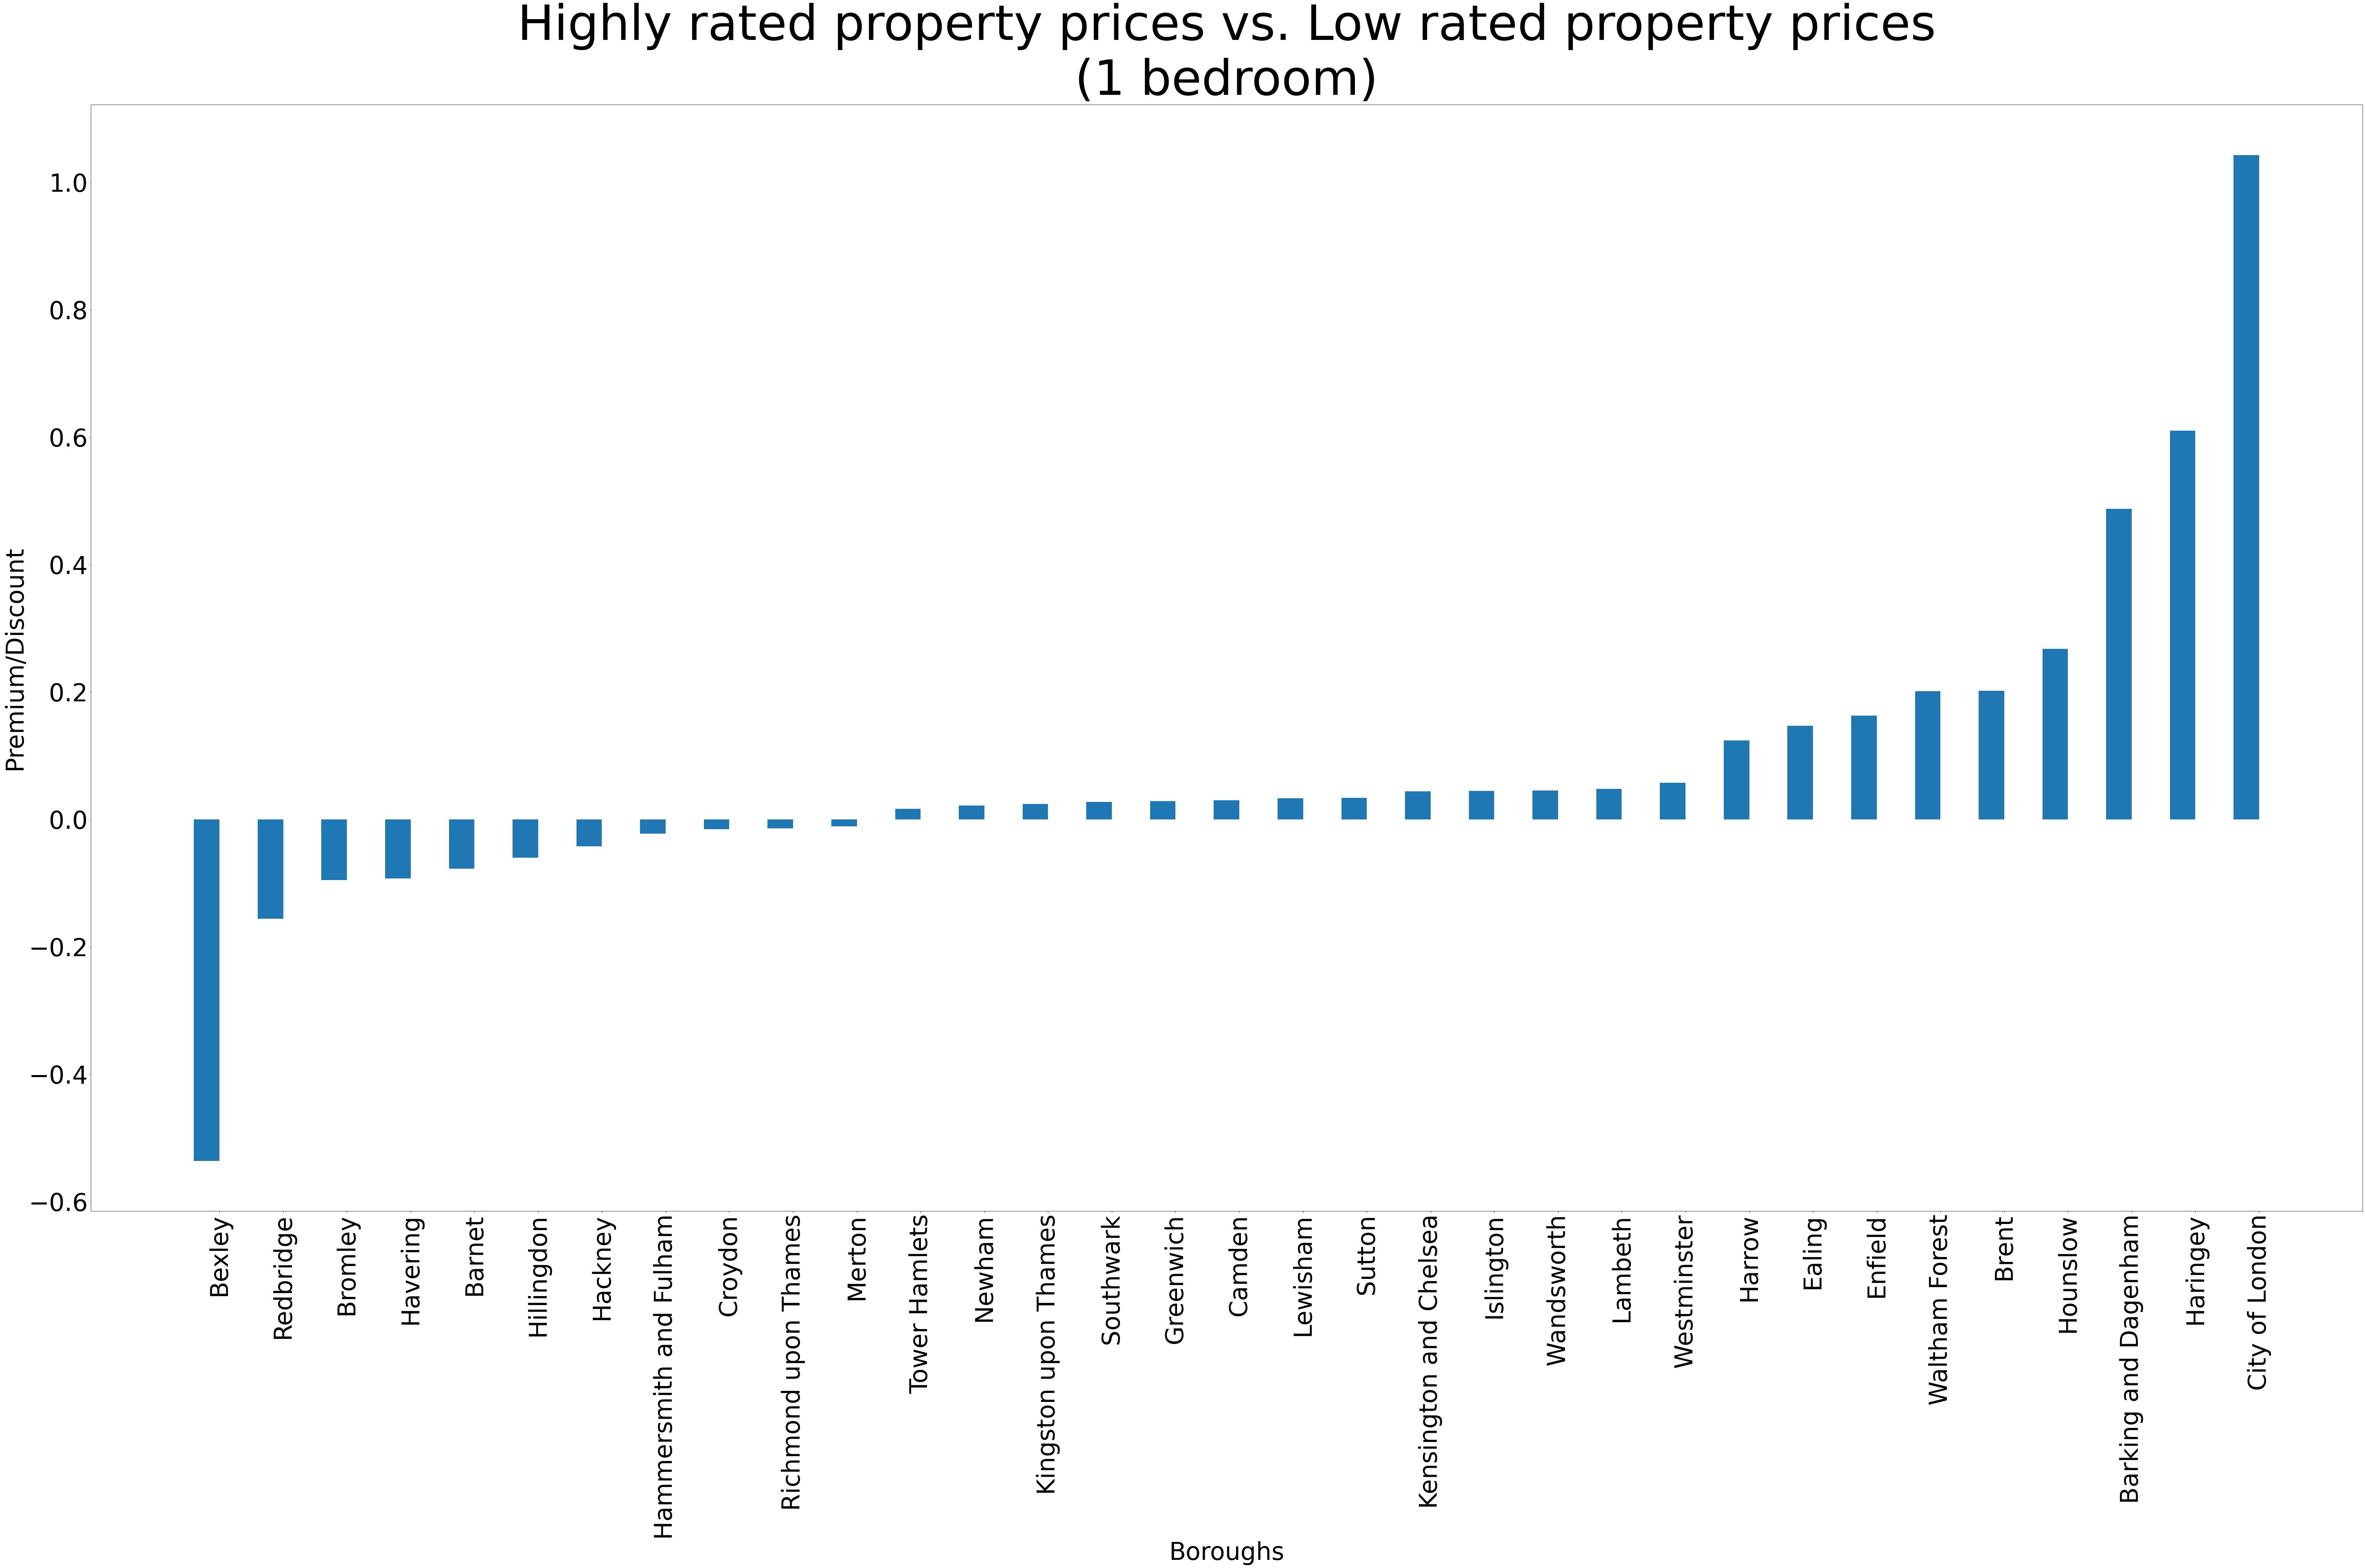

In [66]:
one_bed_df = airbnb.compare_premium('borough', 
              df_premium[(df_premium['above_average_rating']==True)],
              df_premium[(df_premium['above_average_rating']==False)],
              'Highly rated property prices vs. Low rated property prices\n(1 bedroom)',
              'Boroughs',
              'Premium/Discount',True
             )

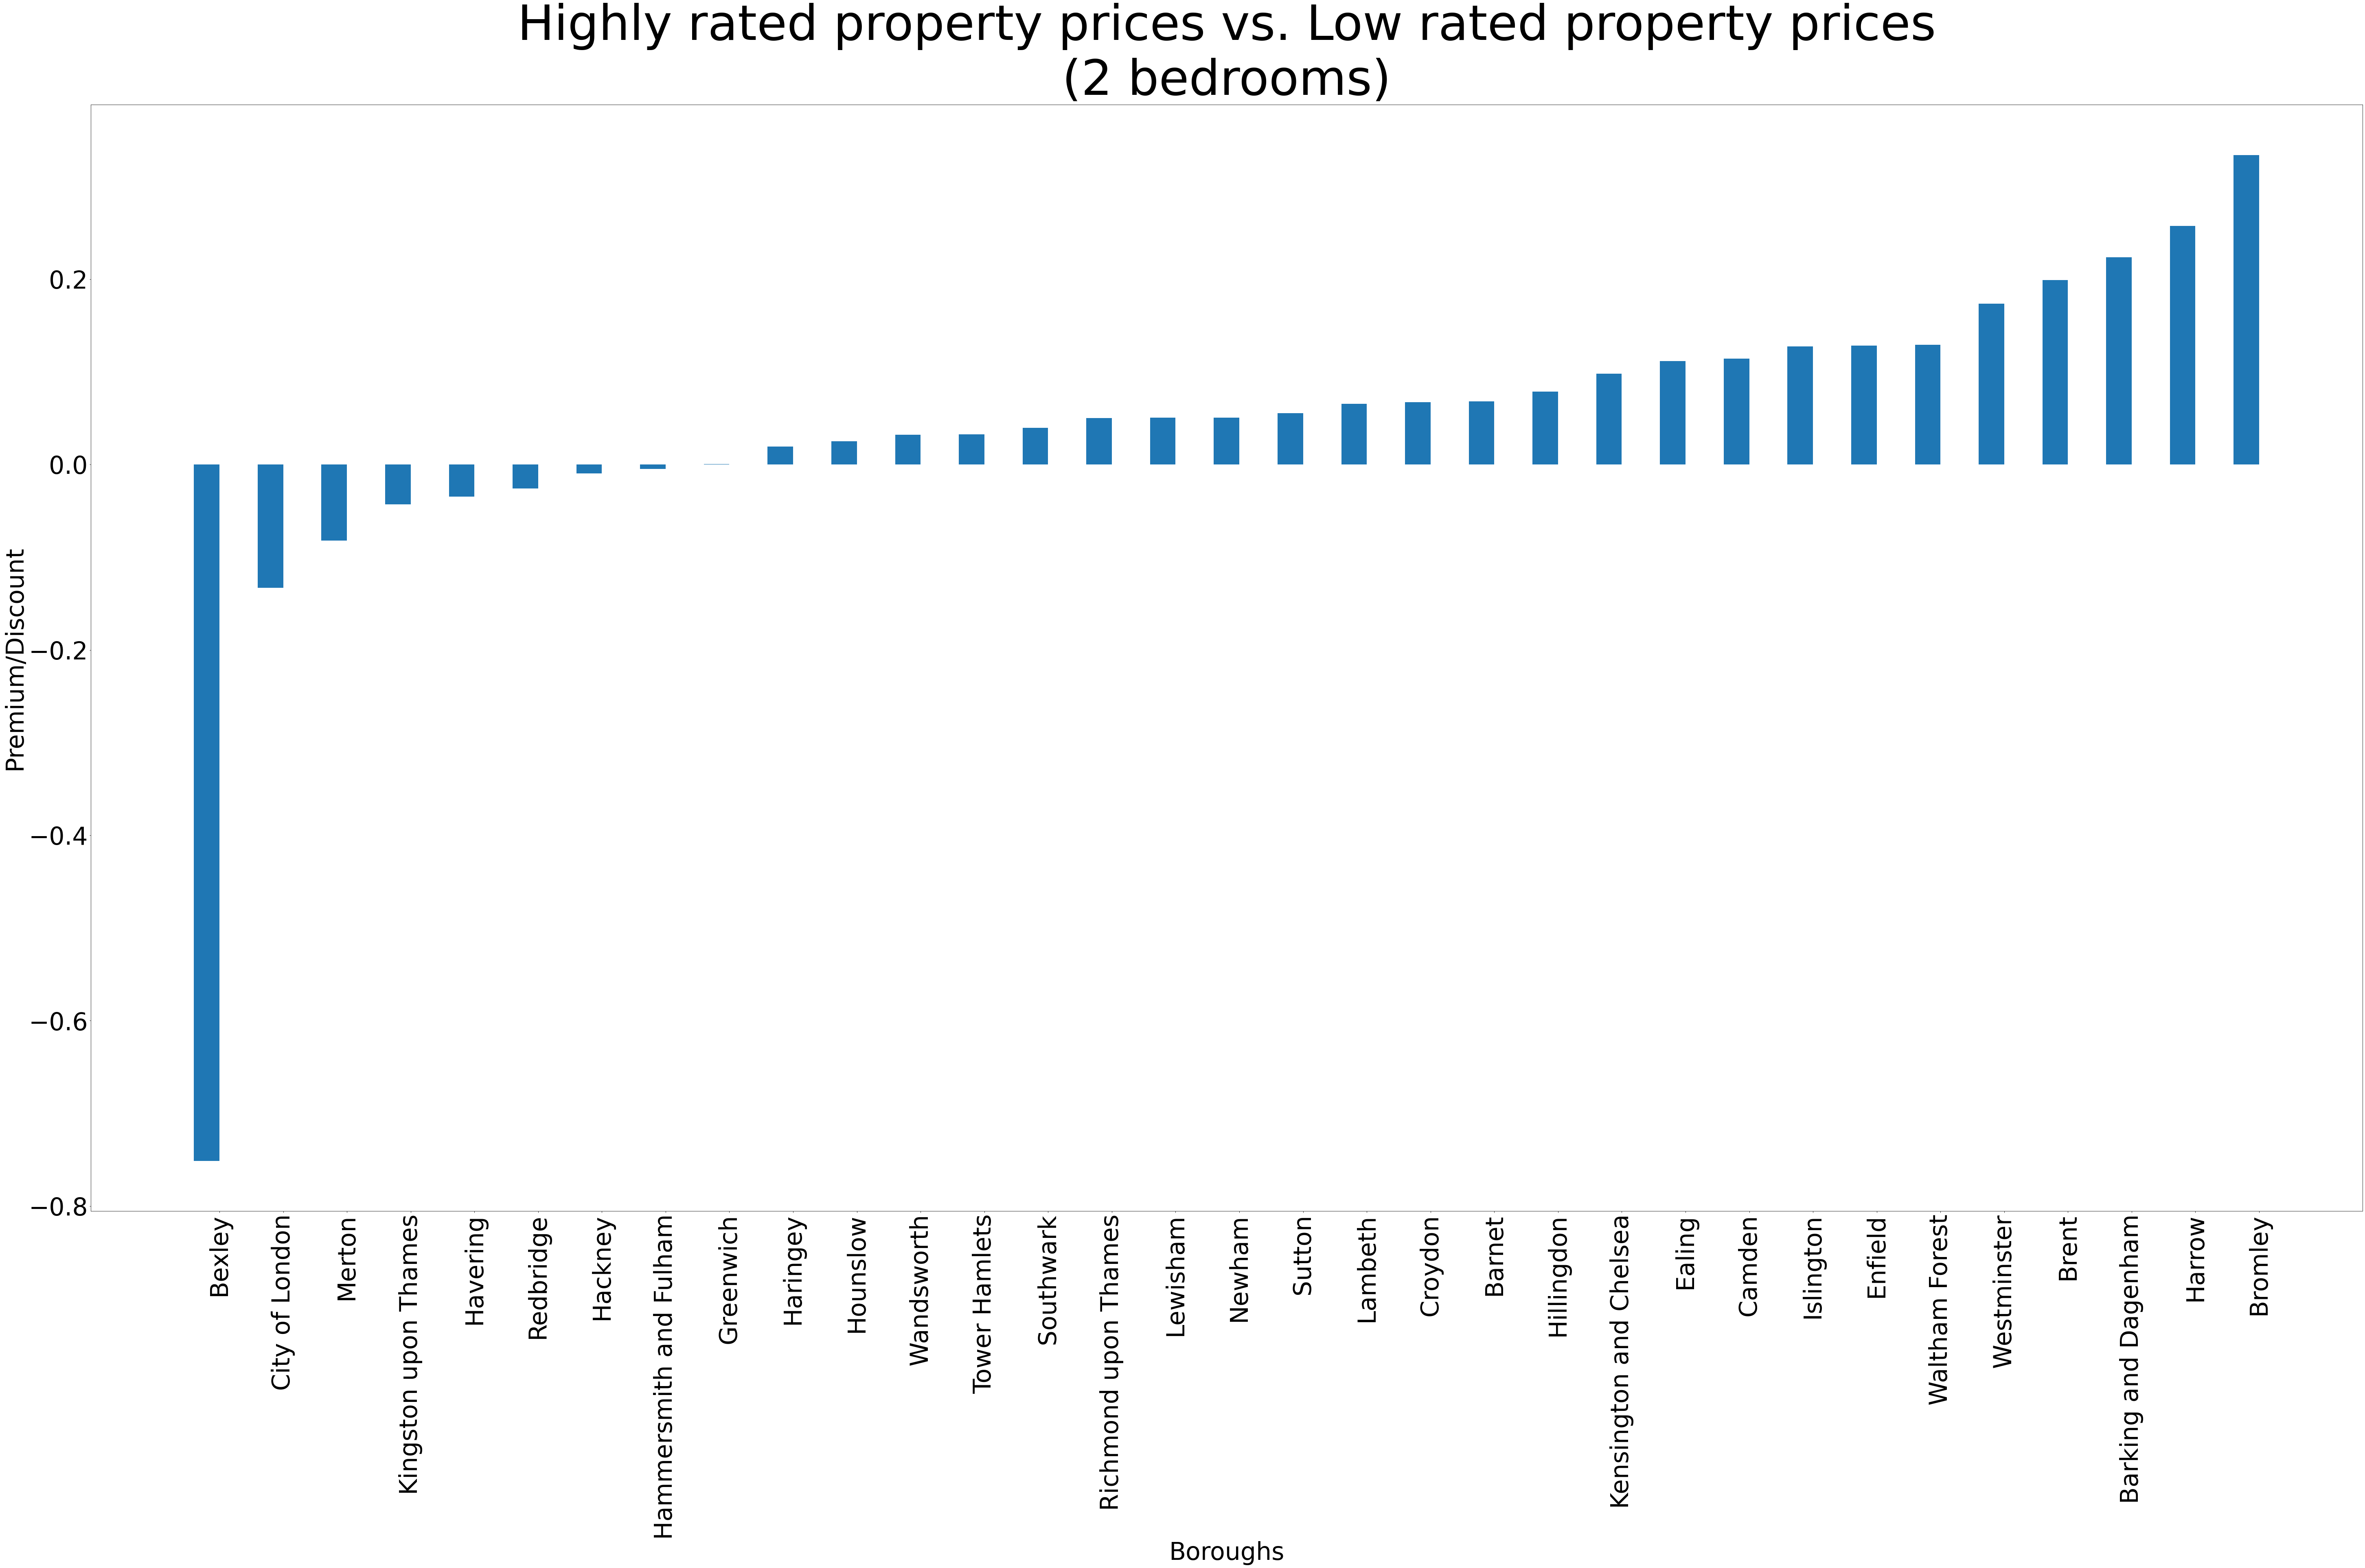

In [67]:
two_bed_df = airbnb.compare_premium('borough', 
              df_premium[(df_premium['above_average_rating']==True)&(df_premium['bedrooms']==2)],
              df_premium[(df_premium['above_average_rating']==False)&(df_premium['bedrooms']==2)],
              'Highly rated property prices vs. Low rated property prices\n(2 bedrooms)',
              'Boroughs',
              'Premium/Discount', True
             )

In [68]:


bedroom_df = pd.concat([one_bed_df.iloc[:,0:2],two_bed_df.iloc[:,1:2]], axis=1, ignore_index=True)

In [69]:
bedroom_df.sort_values(1, inplace=True)

In [70]:
room_types

['Private room', 'Entire home/apt']

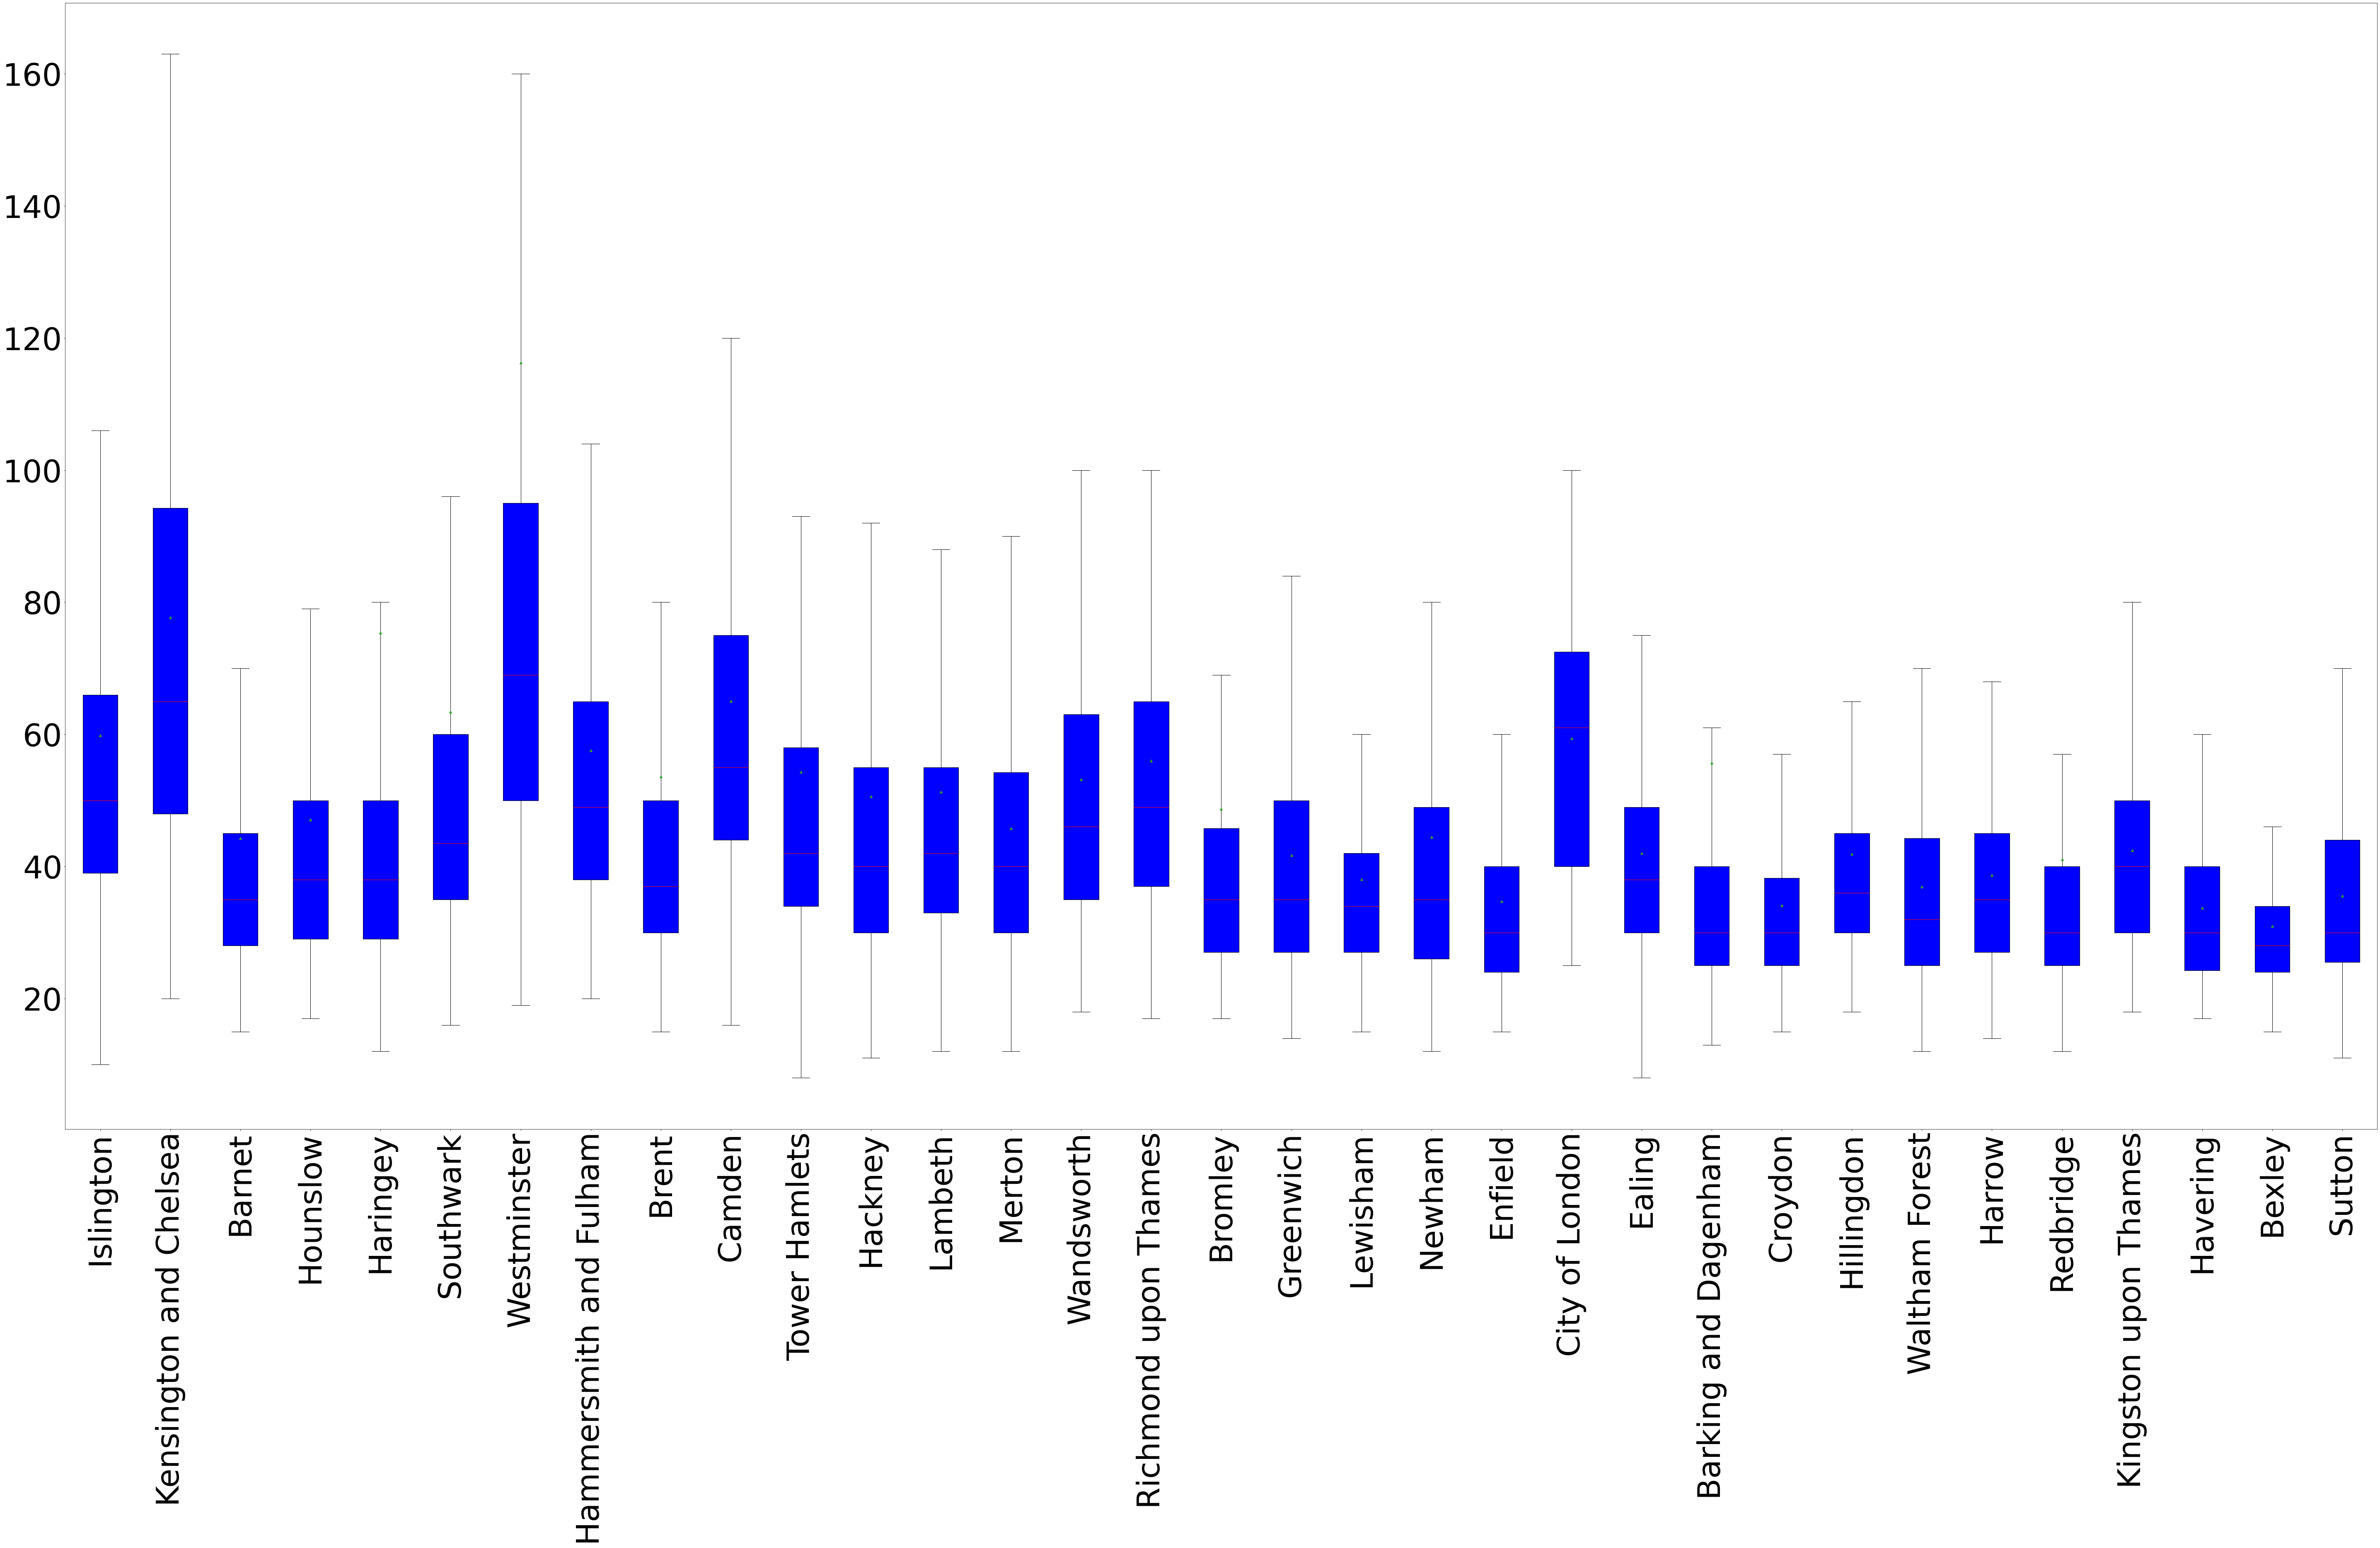

In [71]:

mydict={}
for i in boroughs:
    mydict[i] = df_premium[(df_premium['borough']==i)&(df_premium['room_type']=='Private room')]['price']
    
fig, ax = plt.subplots(figsize=(100,50));

box = ax.boxplot(mydict.values(), showfliers=False, showmeans=True, patch_artist=True);

for b,med,m in zip(box['boxes'], box['medians'], box['means']):
    b.set_facecolor('blue')
    med.set_color('red')
    m.set_color('red')
    
ax.set_xticklabels(mydict.keys());
plt.xticks(rotation=90, fontsize=75);
plt.yticks(fontsize=75);


### The average premium or discount by borough for high and low rated observations

In [72]:
#Mean price for above average rated properties in London
df_premium[df_premium['above_average_rating']==True]['price'].mean()

103.74948528521254

In [73]:
#Mean price for below average rated properties in London
df_premium[df_premium['above_average_rating']==False]['price'].mean()

99.97959582153666

In [74]:
#% of properties that are above average and earn a premium
ap = df_premium[(df_premium['above_average_rating']==True)&(df_premium['premium']==True)].shape[0]/df_premium[df_premium['premium']==True].shape[0]
ap

0.6565015304387257

In [75]:
#% of properties that are below average and earn a premium
bp = df_premium[(df_premium['above_average_rating']==False)&(df_premium['premium']==True)].shape[0]/df_premium[df_premium['premium']==True].shape[0]
bp

0.3434984695612742

In [76]:
#Checking that the above variables sum up to 100% of the dataset
1 == ap+bp

True

/Users/tn/Udacity/data_science_nanodegree/course/projects/project1/airbnb/airbnb_analysis.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ax.get_yticks(),2),fontsize=fontsize)


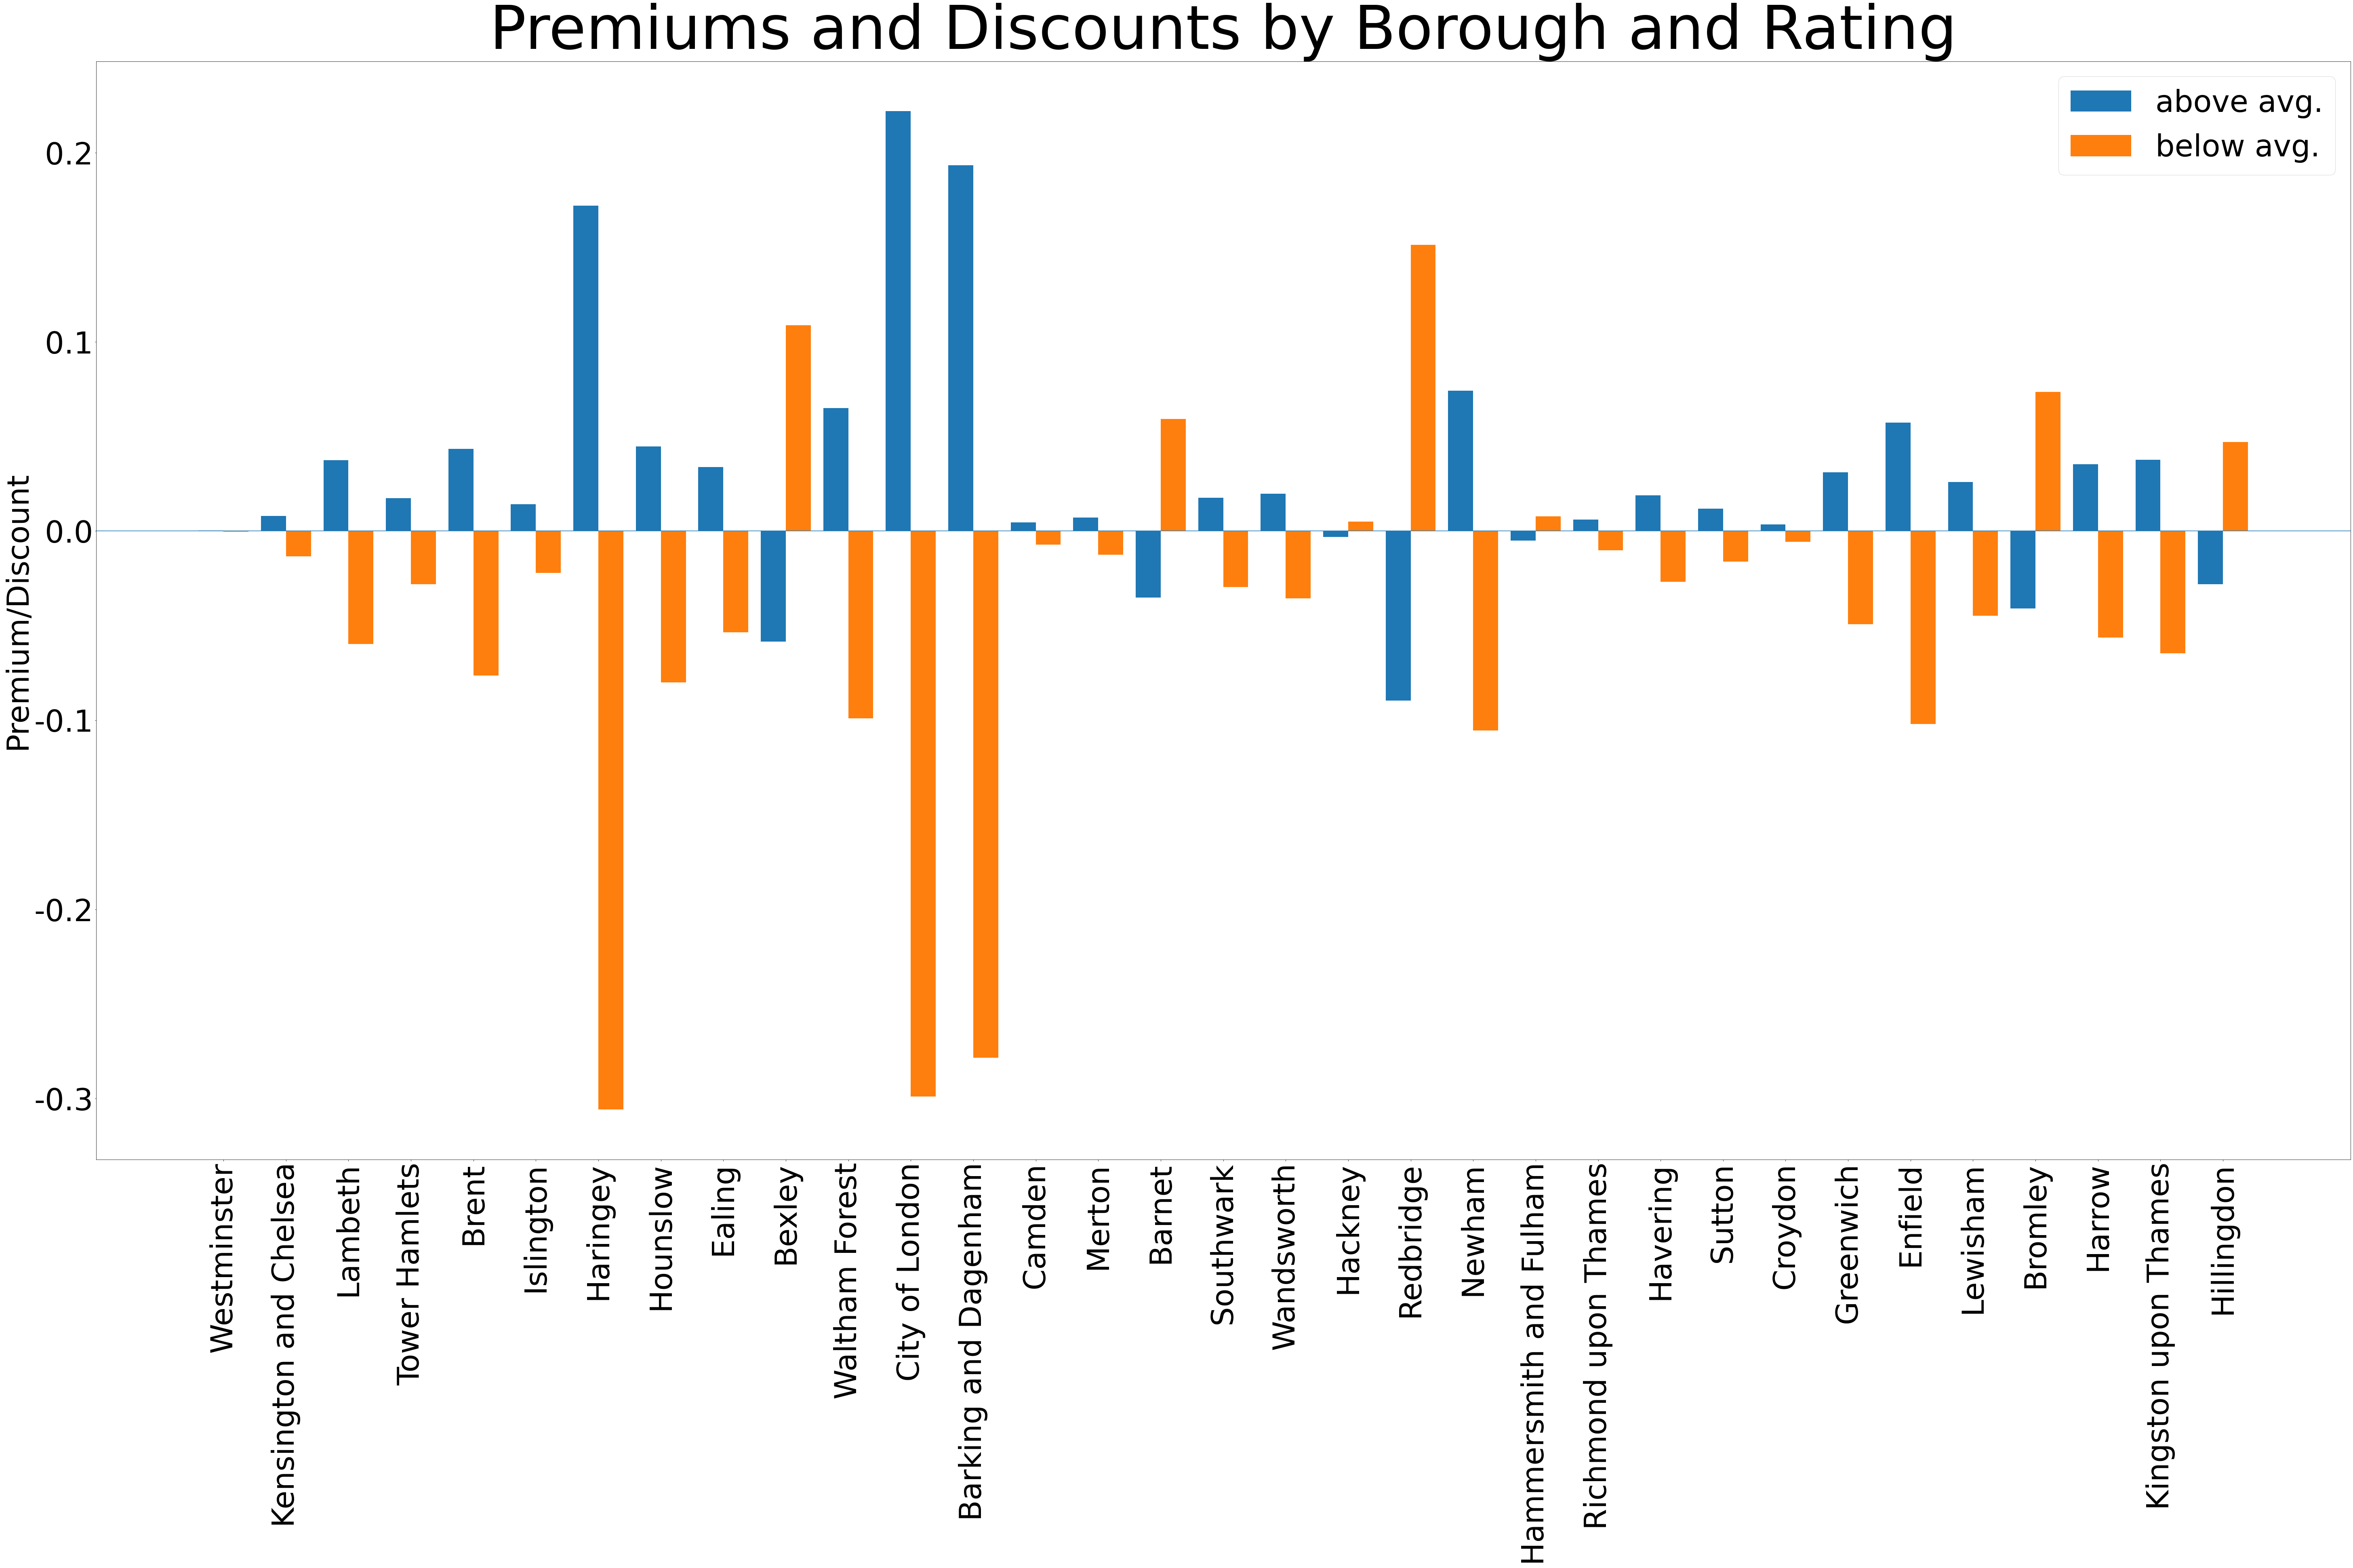

In [77]:
df_graph, fig = airbnb.graph_premium_by('borough', 
              df_premium[(df_premium['above_average_rating']==True)].sort_values(['premium_discount']),
              df_premium[(df_premium['above_average_rating']==False)].sort_values(['premium_discount']),
              'above avg.',
              'below avg.',
              'Premiums and Discounts by Borough and Rating',
              'Boroughs',
              'Premium/Discount'
             )


In [78]:
fig.savefig('graphs/prem_discounts.png')

(         room_type  above_premium above_count  below_premium below_count
 0     Private room       0.012059        7611      -0.020404        4498
 1  Entire home/apt       0.026382        8903      -0.040885        5745,
 <Figure size 7200x3600 with 1 Axes>)

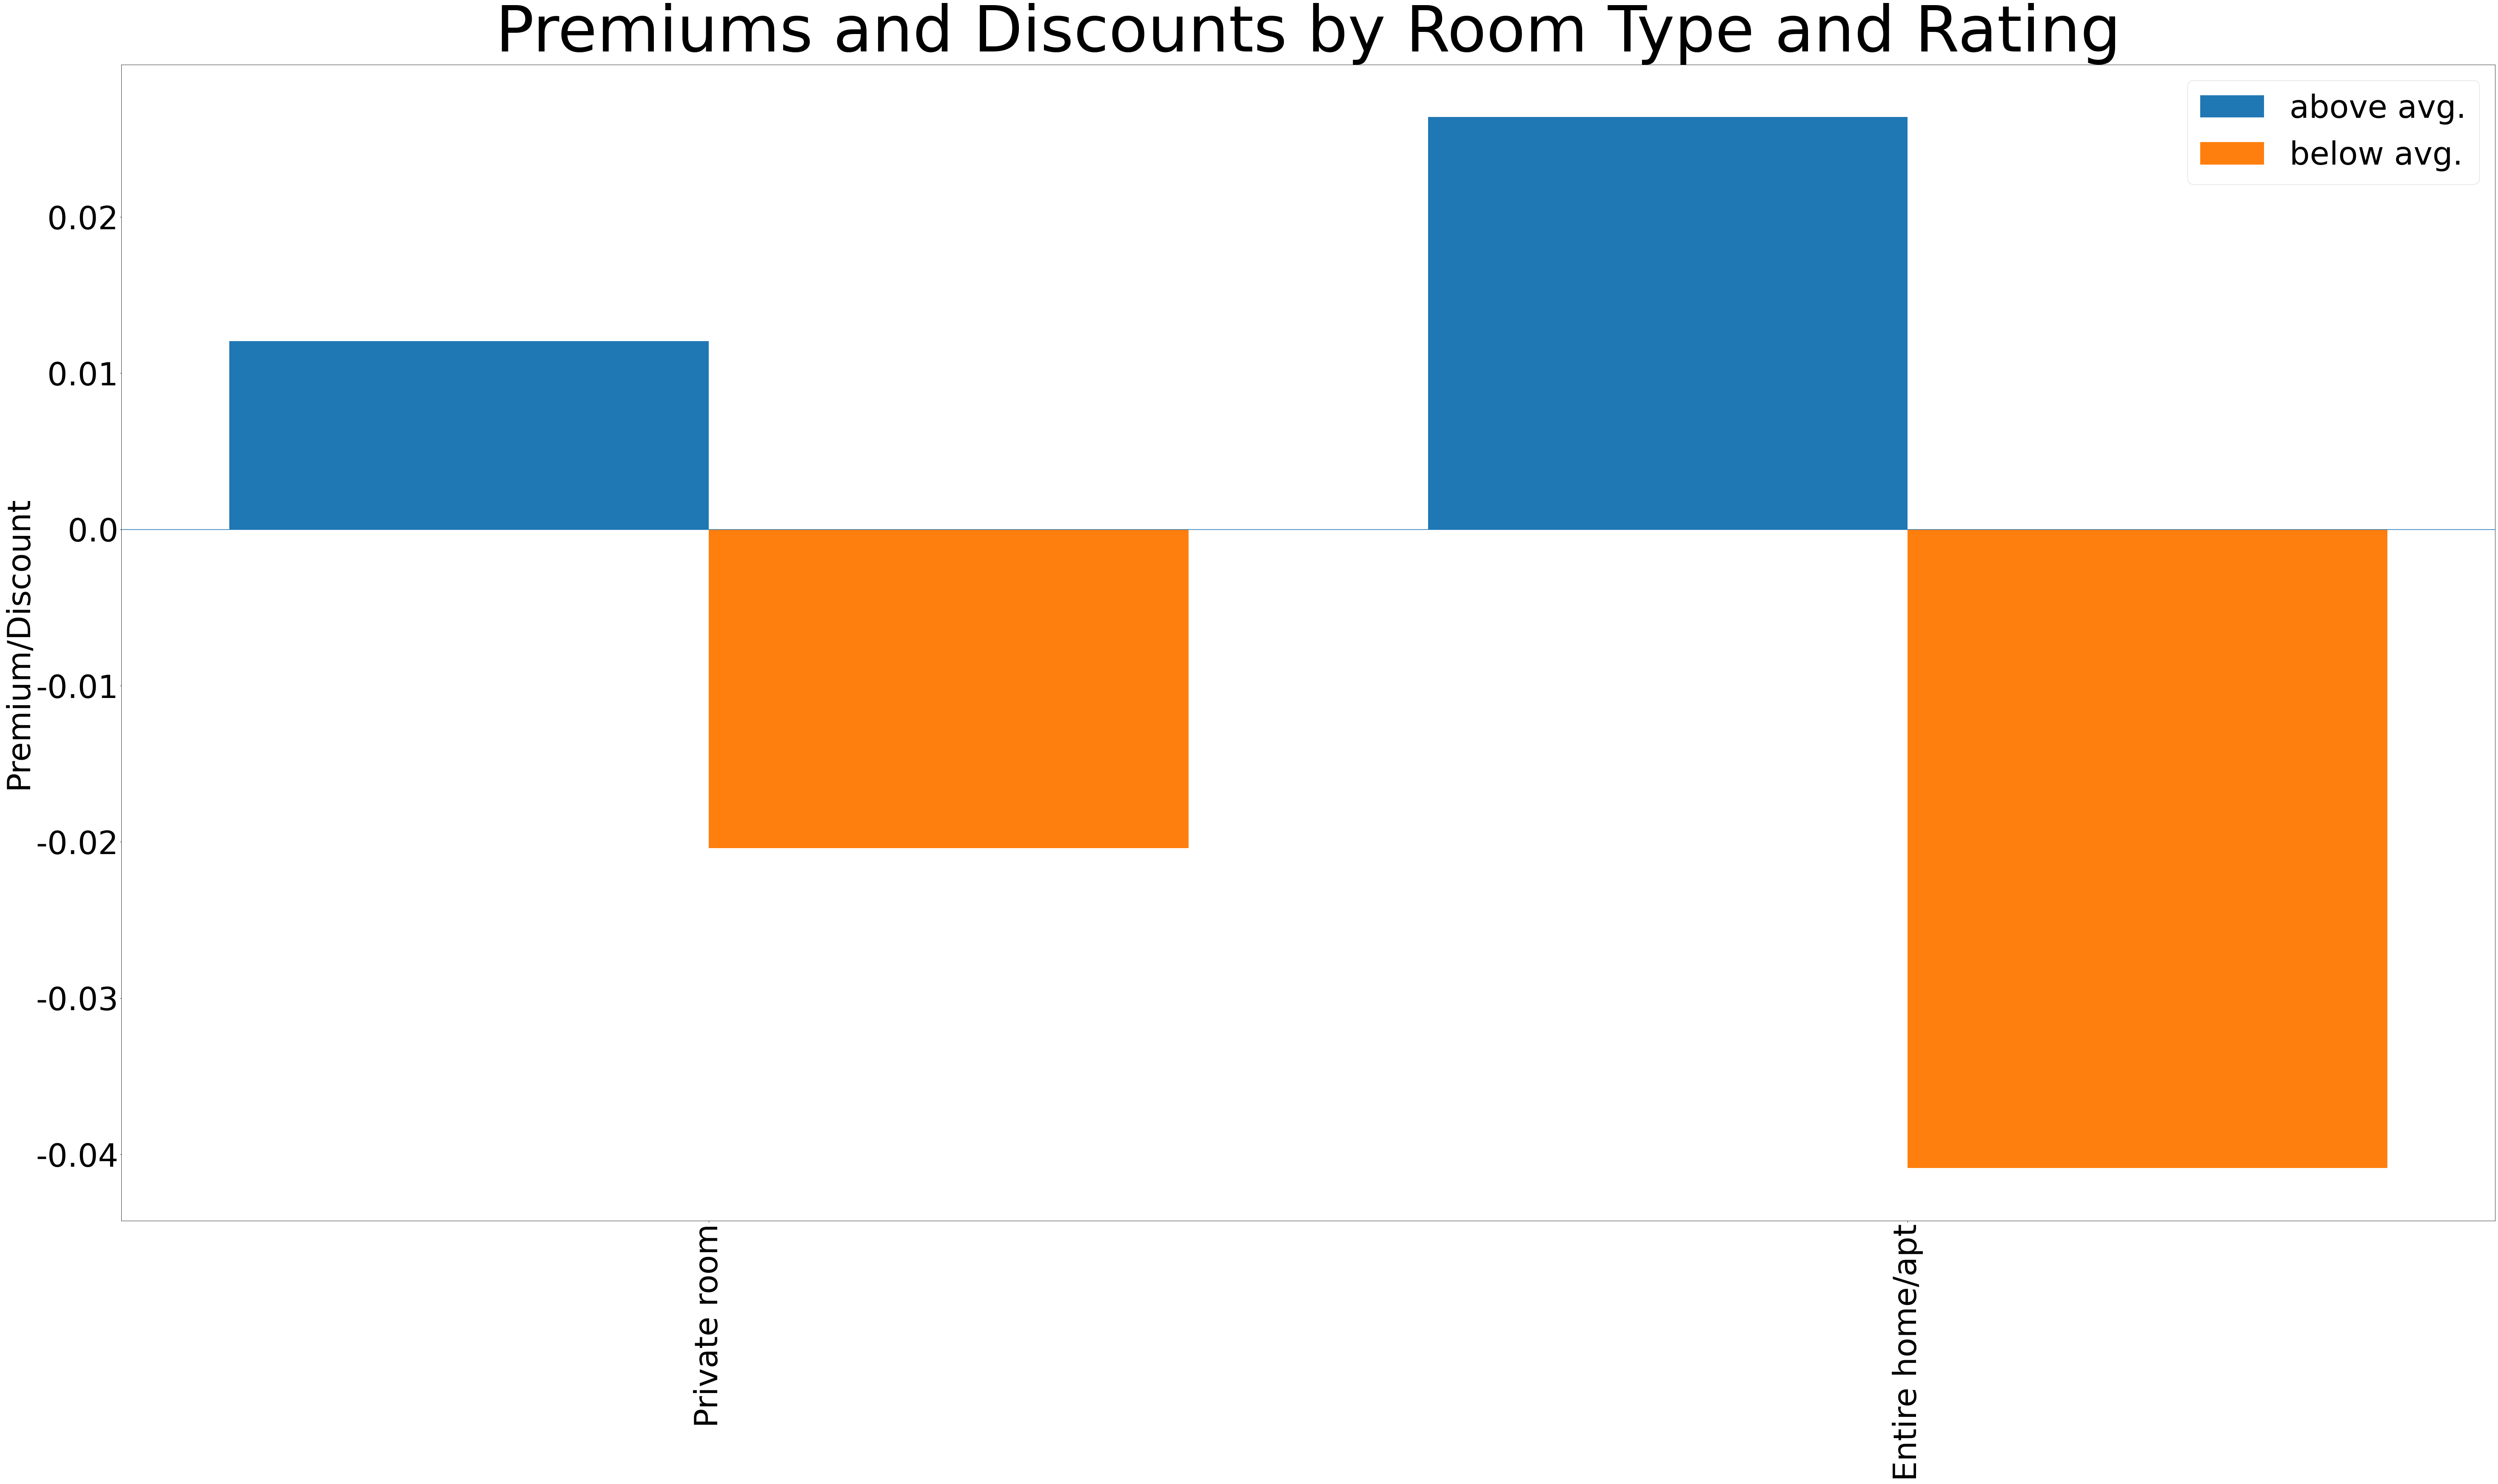

In [79]:
airbnb.graph_premium_by('room_type', 
              df_premium[(df_premium['above_average_rating']==True)],
              df_premium[(df_premium['above_average_rating']==False)],
              'above avg.',
              'below avg.',
              'Premiums and Discounts by Room Type and Rating',
              'Room Type',
              'Premium/Discount'
             )

/Users/tn/Udacity/data_science_nanodegree/course/projects/project1/airbnb/airbnb_analysis.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.around(ax.get_yticks(),2),fontsize=fontsize)


(   bedrooms  above_premium  above_count  below_premium  below_count
 0       1.0       0.017615      12585.0      -0.028960       7655.0
 1       2.0       0.026717       3929.0      -0.040561       2588.0,
 <Figure size 7200x3600 with 1 Axes>)

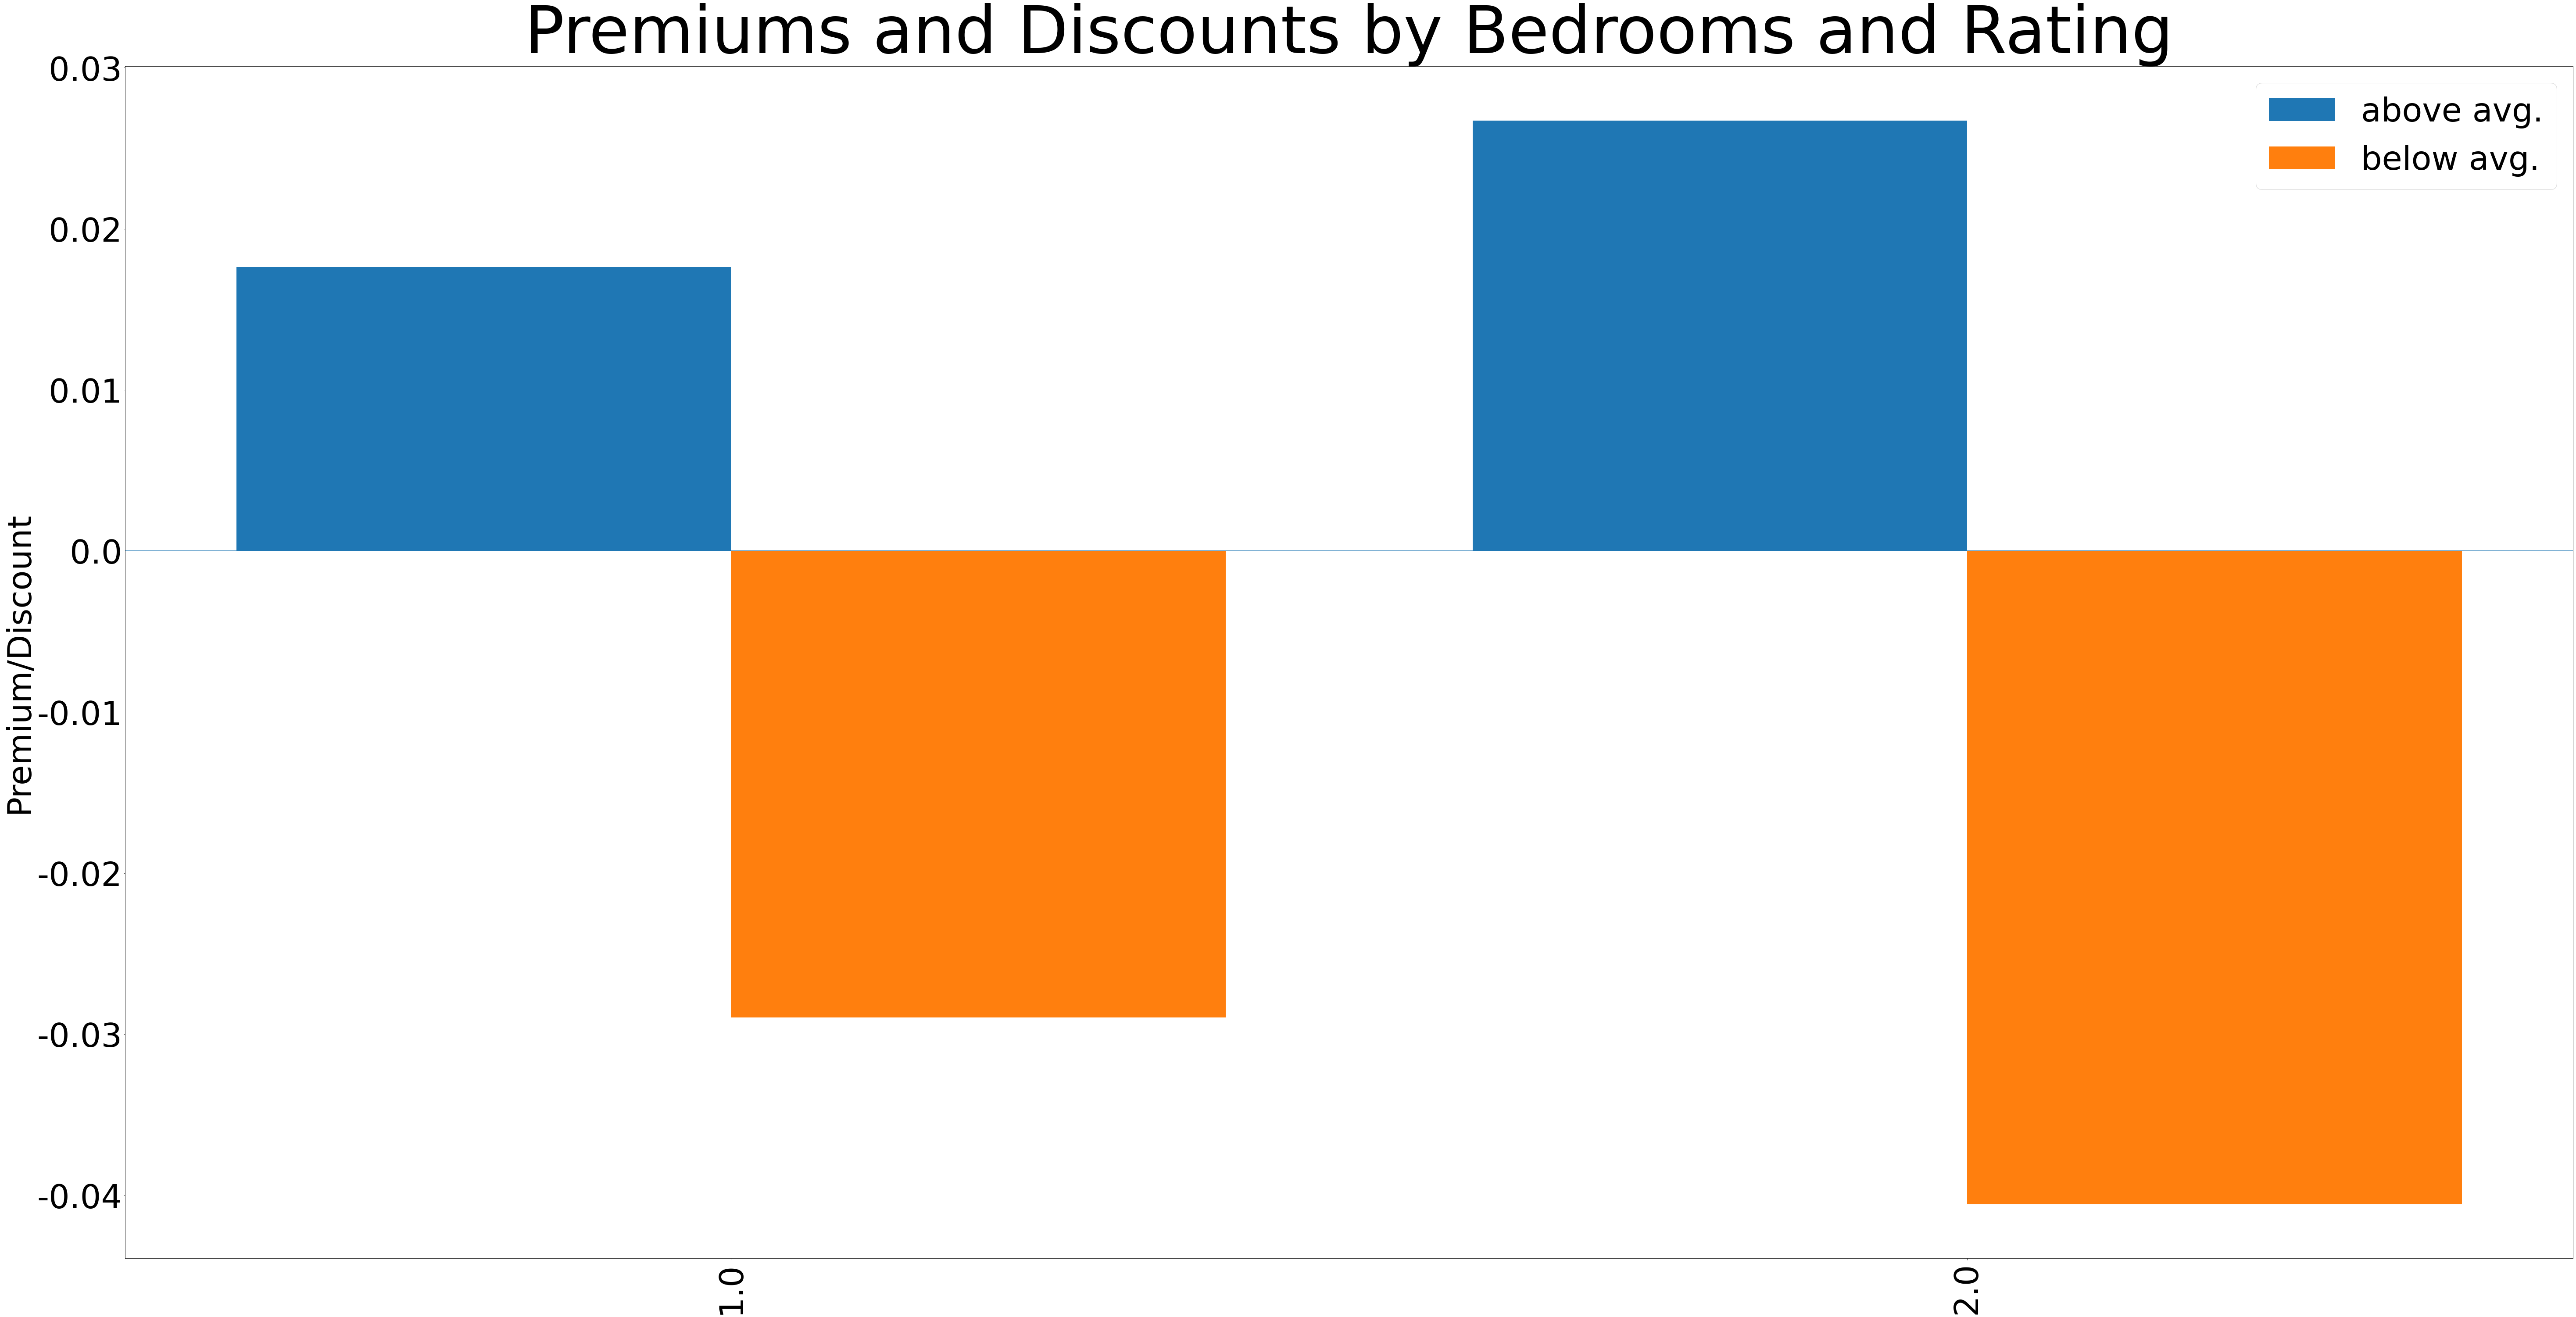

In [80]:
airbnb.graph_premium_by('bedrooms', 
              df_premium[(df_premium['above_average_rating']==True)],
              df_premium[(df_premium['above_average_rating']==False)],
              'above avg.',
              'below avg.',
              'Premiums and Discounts by Bedrooms and Rating',
              'Number of Bedrooms',
              'Premium/Discount'
             )

### The results are consistent. Grouped by any variable (borough, type of unit or number of bedrooms) the data show's that on average, you are more likely to pay a premium for a unit that has above average ratings.